In [1]:
%load_ext autoreload
%autoreload 2
from CO2_identify import *
from labeling import *
from mynetwork import CO2mask
from torch.utils.data import DataLoader
from scipy.ndimage import gaussian_filter
from torchvision.transforms.functional import resize

import torchvision
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
import matplotlib.colors as pcl

In [2]:
fn = '../define_path.txt'      #add your path
with open(fn) as f:
    lines = f.readlines()
for idx, line in enumerate(lines):
    if idx == 1:
        dir_co2 = line.split('=')[1][:-1]
    if idx == 3:
        dir_grid = line.split('=')[1][:-1]
    if idx == 5:
        train_fulllabel = line.split('=')[1][:-1]
    if idx == 7:
        train_sparselabel = line.split('=')[1][:-1]
    if idx == 9:
        testpath = line.split('=')[1][:-1]
    if idx == 11:
        analpath = line.split('=')[1][:-1]

outpath = '/scratch/gilbreth/pate2126/DKP_new/NNpred3D/figures'          #add your path

# 3D patches in Figure 2 

## 3D pactch display function (middle slices, no axes)

In [3]:
# define 3D plot function
def show3D(md, ax=None, xyz=None, xyzi=(0,0,0), ea=(30,-45), clip=1, rcstride=(1,1), clim=None, tl=None):
    r'''plot 3D cube image:
        md-3-D data volume (3darray, float, (n1,n2,n3))
        ax-plot axis (None or a given ax)
        xyz-3-D axes coordinates (list, 1darray, (3,))
        xyzi-position of three slicing image indices (tuple, int, (3,))
        ea-viewing angle (tuple, float, (2,))
        clip-image clipping (scalar, float, <1)
        rcstride-2-D plotting stride (tuple, int, (2,))
        clim-colorbar range (None or tuple, int, (2,)): if it is not None, clip is overwritten'''
    
    # get default coordinates
    nx,ny,nz = md.shape
    if xyz is None:
        xyz = [np.arange(nx),np.arange(ny),np.arange(nz)]
    # slice zero index image along each dimension
    mx = md[xyzi[0],:,:].transpose()
    my = md[:,xyzi[1],:].transpose()
    mz = md[:,:,xyzi[2]].transpose()
    MIN = min([np.amin(mx),np.amin(my),np.amin(mz)])
    MAX = max([np.amax(mx),np.amax(my),np.amax(mz)])
    if clim is None:
        cN = pcl.Normalize(vmin=MIN*clip, vmax=MAX*clip)
        rg = [MIN*clip,(MAX-MIN)*clip]
    else:
        cN = pcl.Normalize(vmin=clim[0], vmax=clim[1])
        rg = [clim[0],clim[1]-clim[0]]
    # plot the model
    if ax is None:
        fig = plt.figure(figsize=plt.figaspect(0.8))
        ax = fig.add_subplot(1,1,1,projection='3d')
    else:
        fig = None
    
    # plot the indicator line
    xi = xyz[0][xyzi[0]]
    yi = xyz[1][xyzi[1]]
    zi = xyz[2][xyzi[2]]
    ax.plot([xi,xi],[xyz[1][0],xyz[1][0]],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xi,xi],[xyz[1][0],xyz[1][-1]],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[yi,yi],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[yi,yi],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[xyz[1][0],xyz[1][0]],[zi,zi],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[xyz[1][0],xyz[1][-1]],[zi,zi],'r-',linewidth=2,zorder=10)
    
    # plot the three surfaces
    ax = slice_show(ax, mz, xyz, 0, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, mx, xyz, 1, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, my, xyz, 2, rg=rg, rcstride=rcstride)
    
    # set the axes
    ax.view_init(elev=ea[0],azim=ea[1])
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.axis('off')

    return fig

def slice_show(ax, ms, xyz, od, rg=None, offset=0, rcstride=(10,10)):
    r'''show specific slice of model'''
    
    if rg is None:
        shift = np.amin(ms)
        normalizer = np.amax(ms)-shift
    else:
        shift = rg[0]
        normalizer = rg[1]
    if normalizer == 0:
        msN = np.zeros_like(ms)+0.5
    else:
        msN = (ms-shift)/normalizer
    colors = plt.cm.gray(msN)
    if od == 0:
        [X,Y] = np.meshgrid(xyz[0],xyz[1])
        Z = np.zeros_like(X)+xyz[2][0]+offset
    if od == 1:
        [Y,Z] = np.meshgrid(xyz[1],xyz[2])
        X = np.zeros_like(Y)+xyz[0][0]+offset
    if od == 2:
        [X,Z] = np.meshgrid(xyz[0],xyz[2])
        Y = np.zeros_like(X)+xyz[1][0]+offset
    surf = ax.plot_surface(X, Y, Z, 
                           facecolors=colors, rstride=rcstride[0], cstride=rcstride[1], zorder=1)
    
    return ax

## Load the full-label training dataset information

In [4]:
# load all training patch information
pathtrain = train_fulllabel
pf = pd.read_csv(f'{pathtrain}/patch_info_train.csv')
pid = pf['Ptch_id']
mid = pf['Mask_id']

## Define the seampled training patch id

In [5]:
train_id = [150]
rs = (64,64,64)
xyzi = (14,13,30)

## readin and show the sampled patches

In [6]:
R0 = []
Rt = []
Mr = []
for i in train_id:
    R0t = np.fromfile(f'{pathtrain}/R0t_{pid[i]}.dat',dtype=np.float32)
    R0t = np.reshape(R0t,(2,rs[0],rs[1],rs[2]))
    R0.append(R0t[0])
    Rt.append(R0t[1])
    mr = np.fromfile(f'{pathtrain}/Mask_{mid[i]}.dat',dtype=np.float32)
    Mr.append(np.reshape(mr,rs))

In [7]:
import os
os.makedirs(f'{outpath}/figures', exist_ok=True)

fig = show3D(R0[i], xyzi=xyzi)
plt.show()

for i in range(len(train_id)):
    fig = show3D(R0[i],xyzi=xyzi)
    plt.show()
    fig.savefig(f'{outpath}/fig2_R0_{i}.png',dpi=300)
    fig = show3D(Rt[i],xyzi=xyzi)
    plt.show()
    fig.savefig(f'{outpath}/fig2_Rt_{i}.png',dpi=300)
    fig = show3D(Mr[i],xyzi=xyzi)
    plt.show()
    fig.savefig(f'{outpath}/fig2_Mr_{i}.png',dpi=300)

IndexError: list index out of range

# Loss plot in Figure 5

## load the training and validating (full label) loss

In [8]:
path_loss = f'= /scratch/gilbreth/pate2126/DKP_new/NNpred3D/train_fullabel'                 #add your path
fn_tl = f'train_loss.dat'
fn_vl = f'valid_loss.dat'
N = 200 # number of epochs

In [9]:
#tloss = np.fromfile(f'{path_loss}/{fn_tl}',dtype=np.float32)
#vloss = np.fromfile(f'{path_loss}/{fn_vl}',dtype=np.float32)
#ep = np.arange(N)

In [10]:
tloss = np.fromfile(f'/scratch/gilbreth/pate2126/DKP_new/NNpred3D/train_fulllabel/train_loss.dat',dtype=np.float32) #add your path
vloss = np.fromfile(f'/scratch/gilbreth/pate2126/DKP_new/NNpred3D/train_fulllabel/valid_loss.dat',dtype=np.float32) #add your path
ep = np.arange(N)

## plot and save the loss plot

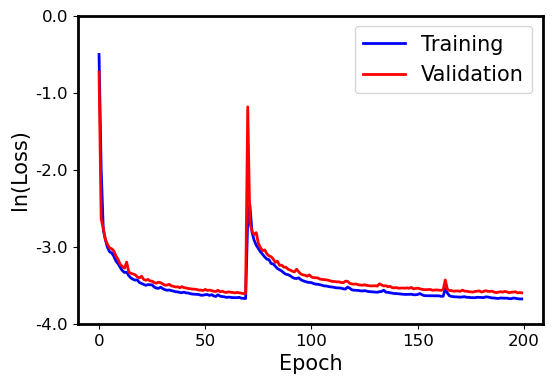

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(ep,np.log(tloss),linewidth=2,color='b',label='Training')
ax.plot(ep,np.log(vloss),linewidth=2,color='r',label='Validation')
ax.set_xlabel('Epoch', fontsize=15)
ax.set_ylabel('ln(Loss)', fontsize=15)

xtick = np.linspace(0,200,5,dtype=np.int16)
ytick = np.linspace(-4,0,5)
ax.set_xticks(xtick)
ax.set_xticklabels([f'{i}' for i in xtick],fontsize=12)
ax.set_yticks(ytick)
ax.set_yticklabels([f'{i:.1f}' for i in ytick],fontsize=12)
ax.legend(fontsize=15)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

In [12]:
BB = ax.get_position()
BB.x0 = -0.3
BB.y0 = -0.3
BB.x1 = 6
BB.y1 = 4
fig.savefig(f'{outpath}/fig5_lnloss.png',dpi=300,bbox_inches=BB)

# Training (full label) patch and predictions display in Fiugre 6

## 3D pactch display function (no axes)

In [13]:
# define 3D plot function
def show3D(md, ax=None, xyz=None, xyzi=(0,0,0), ea=(30,-45), clip=1, rcstride=(1,1), clim=None, tl=None):
    r'''plot 3D cube image:
        md-3-D data volume (3darray, float, (n1,n2,n3))
        ax-plot axis (None or a given ax)
        xyz-3-D axes coordinates (list, 1darray, (3,))
        xyzi-position of three slicing image indices (tuple, int, (3,))
        ea-viewing angle (tuple, float, (2,))
        clip-image clipping (scalar, float, <1)
        rcstride-2-D plotting stride (tuple, int, (2,))
        clim-colorbar range (None or tuple, int, (2,)): if it is not None, clip is overwritten'''
    
    # get default coordinates
    nx,ny,nz = md.shape
    if xyz is None:
        xyz = [np.arange(nx),np.arange(ny),np.arange(nz)]
    # slice zero index image along each dimension
    mx = md[xyzi[0],:,:].transpose()
    my = md[:,xyzi[1],:].transpose()
    mz = md[:,:,xyzi[2]].transpose()
    MIN = min([np.amin(mx),np.amin(my),np.amin(mz)])
    MAX = max([np.amax(mx),np.amax(my),np.amax(mz)])
    if clim is None:
        cN = pcl.Normalize(vmin=MIN*clip, vmax=MAX*clip)
        rg = [MIN*clip,(MAX-MIN)*clip]
    else:
        cN = pcl.Normalize(vmin=clim[0], vmax=clim[1])
        rg = [clim[0],clim[1]-clim[0]]
    # plot the model
    if ax is None:
        fig = plt.figure(figsize=plt.figaspect(0.8))
        ax = fig.add_subplot(1,1,1,projection='3d')
    else:
        fig = None
    
    # plot the indicator line
    xi = xyz[0][xyzi[0]]
    yi = xyz[1][xyzi[1]]
    zi = xyz[2][xyzi[2]]
    ax.plot([xi,xi],[xyz[1][0],xyz[1][0]],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xi,xi],[xyz[1][0],xyz[1][-1]],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[yi,yi],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[yi,yi],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[xyz[1][0],xyz[1][0]],[zi,zi],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[xyz[1][0],xyz[1][-1]],[zi,zi],'r-',linewidth=2,zorder=10)
    
    # plot the three surfaces
    ax = slice_show(ax, mz, xyz, 0, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, mx, xyz, 1, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, my, xyz, 2, rg=rg, rcstride=rcstride)
    
    # set the axes
    ax.view_init(elev=ea[0],azim=ea[1])
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.axis('off')

    return fig

def slice_show(ax, ms, xyz, od, rg=None, offset=0, rcstride=(10,10)):
    r'''show specific slice of model'''
    
    if rg is None:
        shift = np.amin(ms)
        normalizer = np.amax(ms)-shift
    else:
        shift = rg[0]
        normalizer = rg[1]
    if normalizer == 0:
        msN = np.zeros_like(ms)+0.5
    else:
        msN = (ms-shift)/normalizer
    colors = plt.cm.gray(msN)
    if od == 0:
        [X,Y] = np.meshgrid(xyz[0],xyz[1])
        Z = np.zeros_like(X)+xyz[2][0]+offset
    if od == 1:
        [Y,Z] = np.meshgrid(xyz[1],xyz[2])
        X = np.zeros_like(Y)+xyz[0][0]+offset
    if od == 2:
        [X,Z] = np.meshgrid(xyz[0],xyz[2])
        Y = np.zeros_like(X)+xyz[1][0]+offset
    surf = ax.plot_surface(X, Y, Z, 
                           facecolors=colors, rstride=rcstride[0], cstride=rcstride[1], zorder=1)
    
    return ax

## load the training dataset and trained network

In [14]:
# dataset information file names
pmf = 'pm_info.json'
pdf = 'patch_info'
pdfap = '.csv'
# load training dataset
root = train_fulllabel
train = dataset_patch(root,pmf,f'{pdf}_train{pdfap}')
Ntrain = len(train)

In [15]:
#dis_tr = 20
train_id = [214,1357]
rs = (64,64,64)

In [16]:
# network path
path_bestnet = f'/scratch/gilbreth/pate2126/DKP_new/NNpred3D/train_sparselabel/co2_identify_best_sps.pt'      #add your path
# load the network
networktest = CO2mask()
networktest.load_state_dict(torch.load(path_bestnet,map_location=torch.device('cpu')))
networktest = networktest.eval()

/tmp/ipykernel_2100016/3722198958.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  networktest.load_state_dict(torch.load(path_bestnet,map_location=torch.device('cpu')))


In [17]:
r'''
print(train_id)
pst = patch_show(train,train_id)
pst.view3d(rcstride=(2,2))
'''

'\nprint(train_id)\npst = patch_show(train,train_id)\npst.view3d(rcstride=(2,2))\n'

## get the sampled patch and make predictions

In [18]:
R0 = []
Rt = []
pm = []
rm = []
for i in train_id:
    R0t,M,idx = train.__getitem__(i)
    R0t = torch.unsqueeze(R0t,0)
    with torch.no_grad():
        pMask = networktest(R0t).numpy()[0][0]
    R0.append(R0t.numpy()[0][0])
    Rt.append(R0t.numpy()[0][1])
    pm.append(pMask)
    rm.append(M.numpy()[0])

## display patches

In [19]:
pst = patch_show(train,train_id)

In [20]:
pst.ixtid

[[0, 0, 0], [16, 27, 34]]

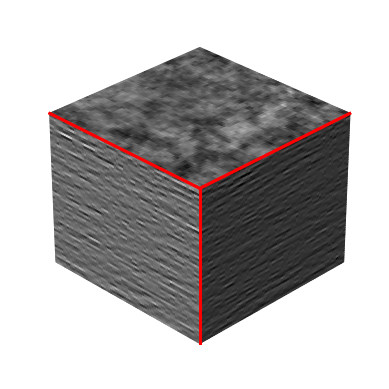

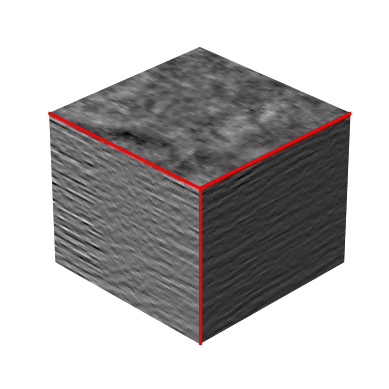

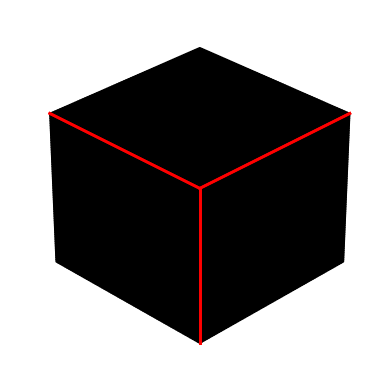

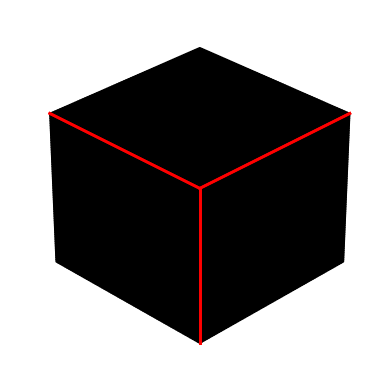

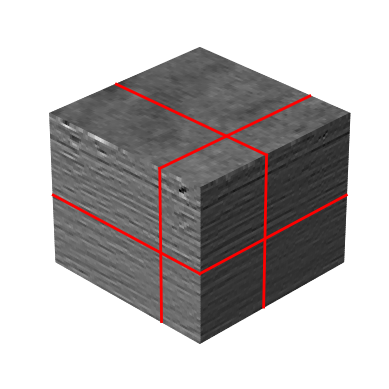

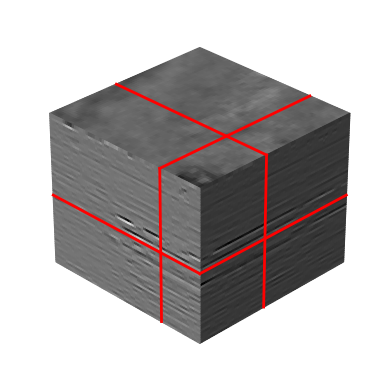

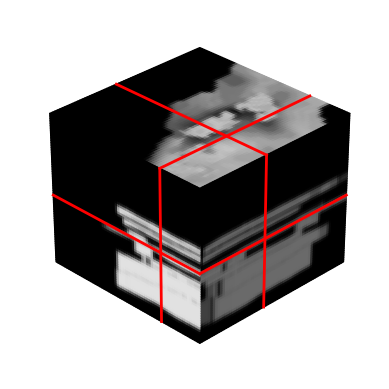

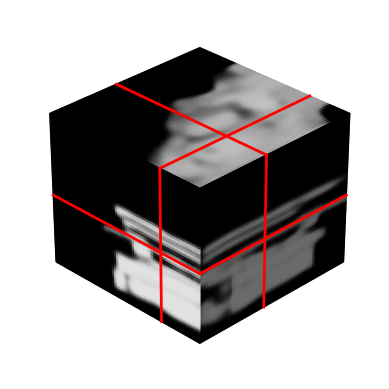

In [21]:
for i in range(len(train_id)):
    fig = show3D(R0[i],xyzi=pst.ixtid[i])
    plt.show()
    fig.savefig(f'{outpath}/fig6_R0_{i}.png',dpi=300)
    fig = show3D(Rt[i],xyzi=pst.ixtid[i])
    plt.show()
    fig.savefig(f'{outpath}/fig6_Rt_{i}.png',dpi=300)
    fig = show3D(rm[i],xyzi=pst.ixtid[i],clim=[0,1])
    plt.show()
    fig.savefig(f'{outpath}/fig6_rm_{i}.png',dpi=300)
    fig = show3D(pm[i],xyzi=pst.ixtid[i],clim=[0,1])
    plt.show()
    fig.savefig(f'{outpath}/fig6_pm_{i}.png',dpi=300)

# Reconstructed 3D predictions and labels for 2010 dataset in Figure 7

## 3D dataset display function (with axes)

In [22]:
# define 3D plot function
def show3D(md, ax=None, xyz=None, xyzi=(0,0,0), ea=(30,-25), clip=1, rcstride=(1,1), clim=None, tl=None):
    r'''plot 3D cube image:
        md-3-D data volume (3darray, float, (n1,n2,n3))
        ax-plot axis (None or a given ax)
        xyz-3-D axes coordinates (list, 1darray, (3,))
        xyzi-position of three slicing image indices (tuple, int, (3,))
        ea-viewing angle (tuple, float, (2,))
        clip-image clipping (scalar, float, <1)
        rcstride-2-D plotting stride (tuple, int, (2,))
        clim-colorbar range (None or tuple, int, (2,)): if it is not None, clip is overwritten'''
    
    # get default coordinates
    nx,ny,nz = md.shape
    if xyz is None:
        xyz = [np.arange(nx),np.arange(ny),np.arange(nz)]
    # slice zero index image along each dimension
    mx = md[xyzi[0],:,:].transpose()
    my = md[:,xyzi[1],:].transpose()
    mz = md[:,:,xyzi[2]].transpose()
    MIN = min([np.amin(mx),np.amin(my),np.amin(mz)])
    MAX = max([np.amax(mx),np.amax(my),np.amax(mz)])
    if clim is None:
        cN = pcl.Normalize(vmin=MIN*clip, vmax=MAX*clip)
        rg = [MIN*clip,(MAX-MIN)*clip]
    else:
        cN = pcl.Normalize(vmin=clim[0], vmax=clim[1])
        rg = [clim[0],clim[1]-clim[0]]
    # plot the model
    if ax is None:
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(1,1,1,projection='3d')
    else:
        fig = None
    
    # plot the indicator line
    xi = xyz[0][xyzi[0]]
    yi = xyz[1][xyzi[1]]
    zi = xyz[2][xyzi[2]]
    ax.plot([xi,xi],[xyz[1][0],xyz[1][0]],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xi,xi],[xyz[1][0],xyz[1][-1]],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[yi,yi],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[yi,yi],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[xyz[1][0],xyz[1][0]],[zi,zi],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[xyz[1][0],xyz[1][-1]],[zi,zi],'r-',linewidth=2,zorder=10)
    
    # plot the three surfaces
    ax = slice_show(ax, mz, xyz, 0, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, mx, xyz, 1, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, my, xyz, 2, rg=rg, rcstride=rcstride)
    
    # set the axes
    ax.set_xticks(np.linspace(0,4000,3))
    ax.set_yticks(np.linspace(0,8000,5))
    ax.set_zticks(np.linspace(0,2,5))
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(15)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(15) 
    for tick in ax.zaxis.get_major_ticks():
        tick.label1.set_fontsize(15) 
    if tl is not None:
        ax.set_title(tl,fontsize=15)
    ax.view_init(elev=ea[0],azim=ea[1])
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.set_xlabel('Inline (m)',fontsize=20,labelpad=20)
    ax.set_ylabel('Xline (m)',fontsize=20,labelpad=20)
    ax.set_zlabel('T (s)',fontsize=20,labelpad=10)

    return fig

def slice_show(ax, ms, xyz, od, rg=None, offset=0, rcstride=(10,10)):
    r'''show specific slice of model'''
    
    if rg is None:
        shift = np.amin(ms)
        normalizer = np.amax(ms)-shift
    else:
        shift = rg[0]
        normalizer = rg[1]
    if normalizer == 0:
        msN = np.zeros_like(ms)+0.5
    else:
        msN = (ms-shift)/normalizer
    colors = plt.cm.gray(msN)
    if od == 0:
        [X,Y] = np.meshgrid(xyz[0],xyz[1])
        Z = np.zeros_like(X)+xyz[2][0]+offset
    if od == 1:
        [Y,Z] = np.meshgrid(xyz[1],xyz[2])
        X = np.zeros_like(Y)+xyz[0][0]+offset
    if od == 2:
        [X,Z] = np.meshgrid(xyz[0],xyz[2])
        Y = np.zeros_like(X)+xyz[1][0]+offset
    surf = ax.plot_surface(X, Y, Z, 
                           facecolors=colors, rstride=rcstride[0], cstride=rcstride[1], zorder=1)
    
    return ax

## display the 3D reconstructed labels and predictions

In [23]:
# readin reference dataset information
xydfn = f'{dir_co2}/10p10/data/10p10nea.sgy'  #add your path
Dr = dataload(fn=xydfn)
_,xd,yd,td = Dr.getdata()
DD = (Dr.nx,Dr.ny,Dr.nt)

Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)


In [24]:
# generate X,Y and Z
xm = np.amin(xd)
ym = np.amin(yd)
x = xd[:,0]-xm
y = yd[0,:]-ym
z = td
xyz = [x,y,z]

In [25]:
# define path and fn for NN tests
path_2010 = testpath
fn_bl = ['2010_b01_t10','2010_b01_t11','2010_b10_t10','2010_b10_t11']
fn_tsMask = f'tsMask.dat'
nfn = len(fn_bl)
print (path_2010)

/scratch/gilbreth/pate2126/DKP_new/NNpred3D/pred_results


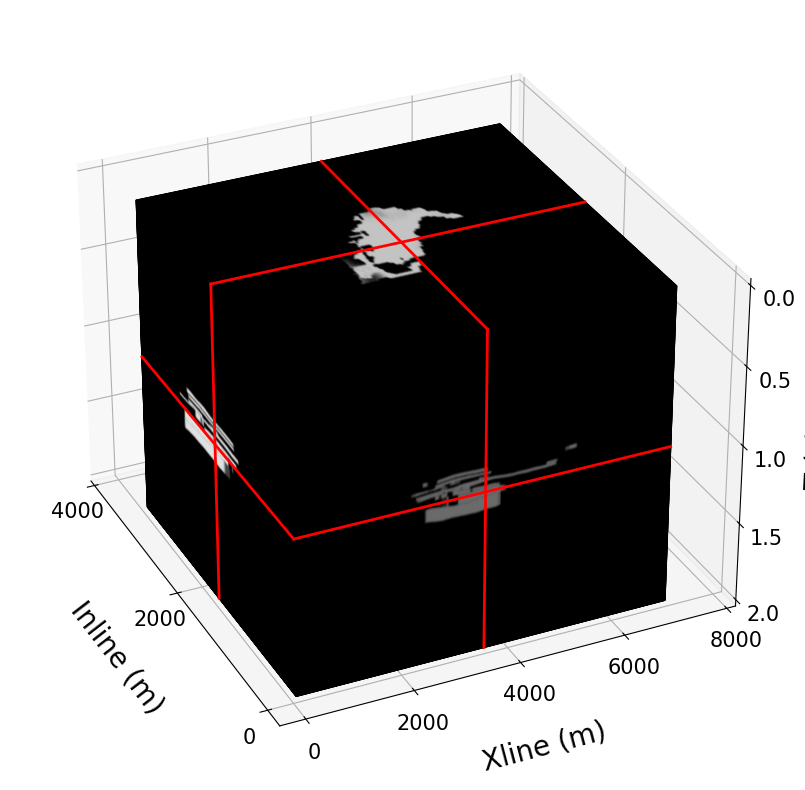

In [26]:
# readin CO2 mask
mkfn = f'../resources/label/masks.dat'
masks = np.fromfile(f'{mkfn}',dtype=np.float32)
mask_ref = np.reshape(masks,DD)
fig = show3D(mask_ref,xyz=xyz,xyzi=(DD[0]//2,DD[1]//2,DD[2]//2),clim=[0,1])
fig.savefig(f'{outpath}/fig7_mask_ref.png',dpi=300)

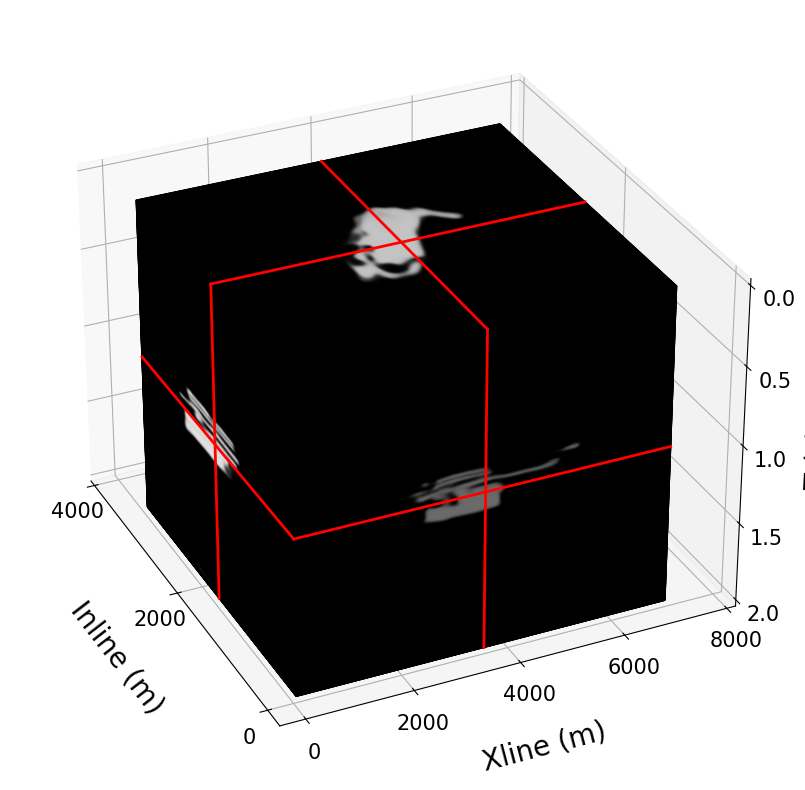

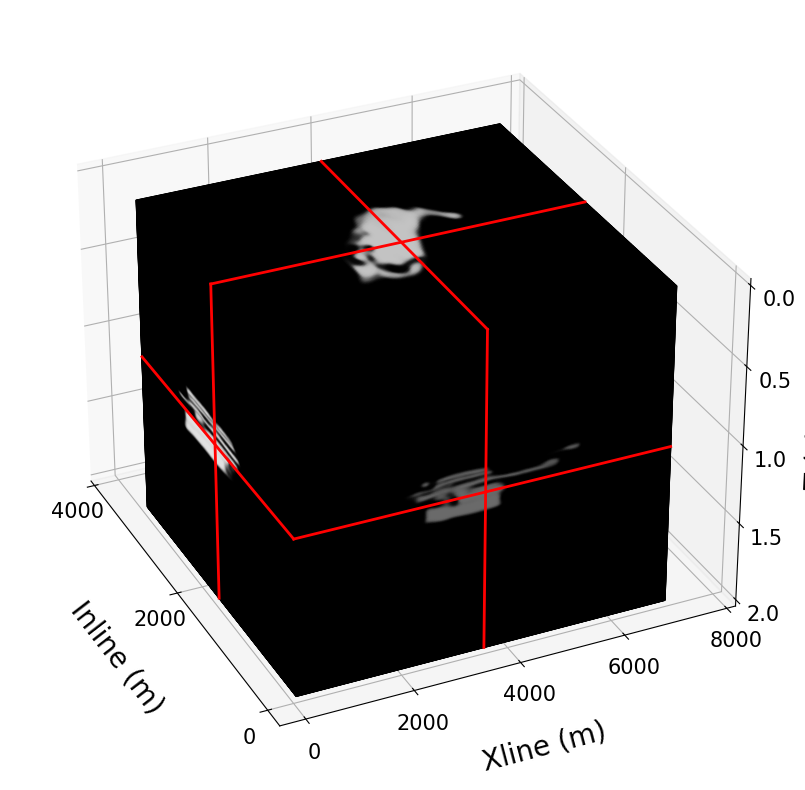

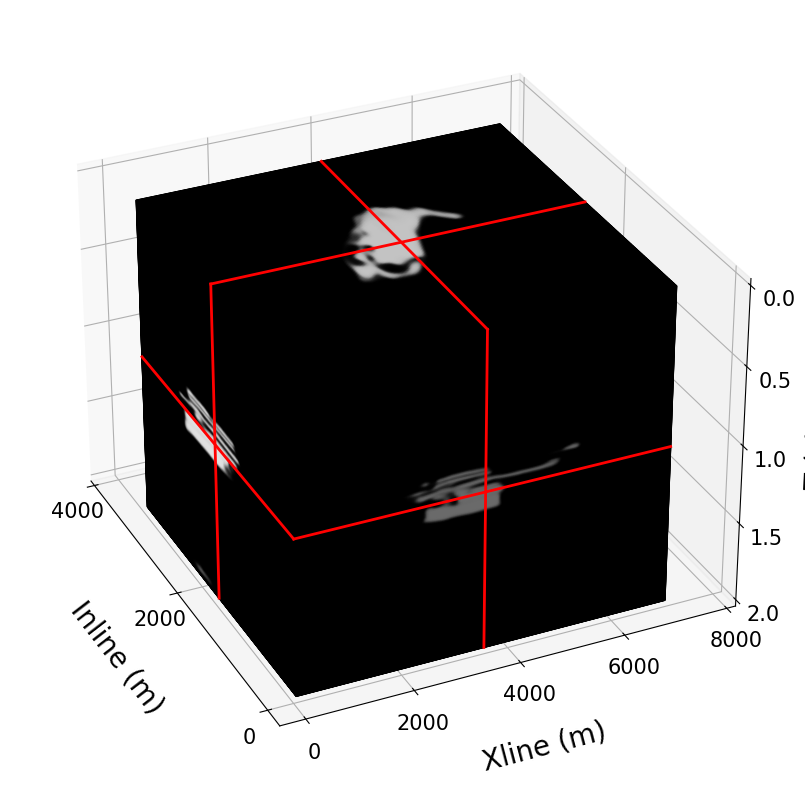

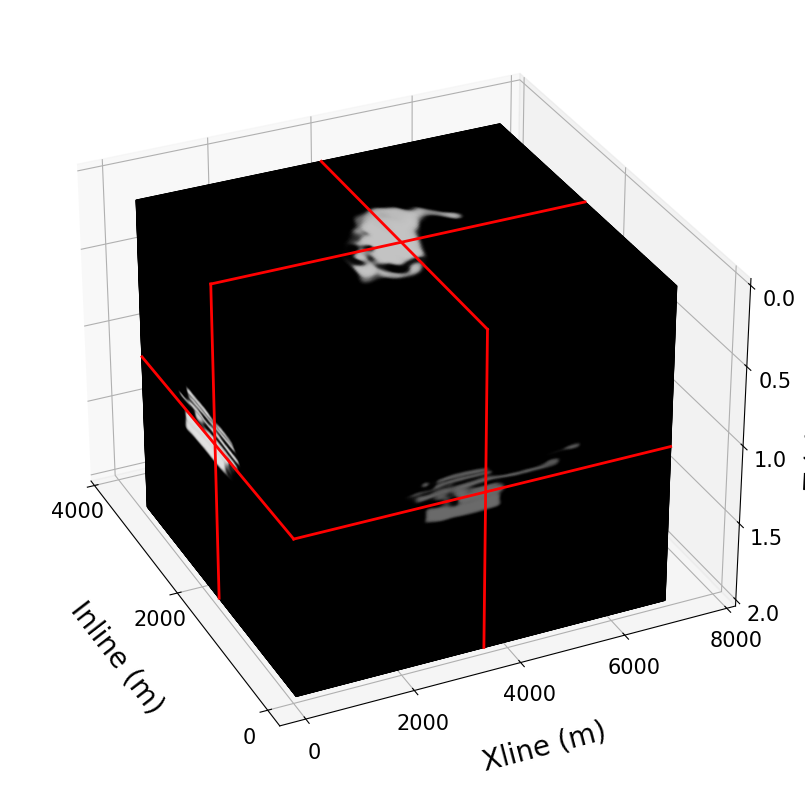

In [27]:
for i in range(nfn):
    mask= np.fromfile(f'{path_2010}/{fn_bl[i]}/test/tsMask.dat',dtype=np.float32)
    mask = np.reshape(mask,DD)
    fig = show3D(mask,xyz=xyz,xyzi=(DD[0]//2,DD[1]//2,DD[2]//2),clim=[0,1])
    fig.savefig(f'{outpath}/fig7_mask_pred_{fn_bl[i]}.png',dpi=300)

# 2D layer view for top sand wedge layer in Figure 8

## load the reference mask, images and traveltime interfaces

In [28]:
N = 9 # number of CO2 layers
lyidx = [0]
nl = len(lyidx)

In [29]:
# readin reference dataset information
xydfn = f'{dir_co2}/10p10/data/10p10nea.sgy'     #add your path
Dr = dataload(fn=xydfn)
_,xd,yd,td = Dr.getdata()
DD = (Dr.nx,Dr.ny,Dr.nt)

Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)


In [30]:
xa = xd[:,0]-np.amin(xd[:,0])
ya = yd[0,:]-np.amin(yd[0,:])

In [31]:
# load the T_top and T_base 
T_top = np.fromfile(f'/scratch/gilbreth/pate2126/DKP_new/resources/label/T_top.dat',dtype=np.float64)       #add your path
T_base = np.fromfile(f'/scratch/gilbreth/pate2126/DKP_new/resources/label/T_base.dat',dtype=np.float64)    #add your path
T_top = np.reshape(T_top,(N,DD[0],DD[1]))
T_base = np.reshape(T_base,(N,DD[0],DD[1]))

In [32]:
# load the reference mask
mkfn = f'/scratch/gilbreth/pate2126/DKP_new/resources/label/masks.dat'          #add your path
masks = np.fromfile(f'{mkfn}',dtype=np.float32)
mask_ref = np.reshape(masks,DD)

In [33]:
print (mkfn)

/scratch/gilbreth/pate2126/DKP_new/resources/label/masks.dat


In [34]:
# load the images
path2010 = ['2010_b01_t10','2010_b01_t11','2010_b10_t10','2010_b10_t11']
nfn = len(path2010)
d0 = np.fromfile(f'{testpath}/{path2010[0]}/test/d0.dat',dtype=np.float32);
d0 = np.reshape(d0,DD)
dt = np.fromfile(f'{testpath}/{path2010[0]}/test/dt.dat',dtype=np.float32);
dt = np.reshape(dt,DD)

In [35]:
# load the predictions
M = []
for i in range(nfn):
    mask= np.fromfile(f'{testpath}/{path2010[i]}/test/tsMask.dat',dtype=np.float32)
    mask = np.reshape(mask,DD)
    M.append(mask)

In [36]:
# derive the top layer information
dta = np.abs(dt)
d0a = np.abs(d0)
ldta = np.zeros((nl,DD[0],DD[1]),dtype=np.float32)
ld0a = np.zeros((nl,DD[0],DD[1]),dtype=np.float32)
lmr = np.zeros((nl,DD[0],DD[1]),dtype=np.float32)
lmp = np.zeros((nfn,nl,DD[0],DD[1]),dtype=np.float32)
for i,j in product(range(DD[0]),range(DD[1])):
    for c,k in enumerate(lyidx):
        Ttk = T_top[N-k-1,i,j]
        Tbk = T_base[N-k-1,i,j]
        mk = (td>=Ttk) * (td<=Tbk)
        if np.sum(mk) == 0:
            continue
        ldta[c,i,j] = np.mean(dta[i,j,mk])
        ld0a[c,i,j] = np.mean(d0a[i,j,mk])
        lmr[c,i,j] = np.mean(mask_ref[i,j,mk])
        for n in range(nfn):
            lmp[n,c,i,j] = np.mean(M[n][i,j,mk])   

## display the amplitude difference

plot layer No. 0.
plot of the absolute amplitude differences between 94p10 and 10p10:


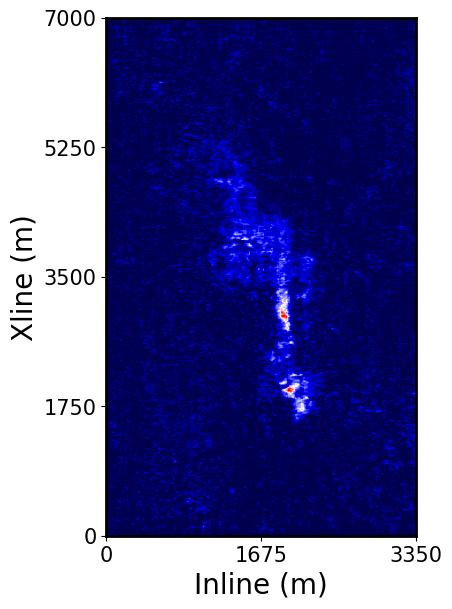

In [37]:
for i in range(nl):
    print(f'plot layer No. {lyidx[i]}.')
    print(f'plot of the absolute amplitude differences between 94p10 and 10p10:')
    fig,ax = plt.subplots(1,1,figsize=(4,8))
    ax.imshow((ldta[i]-ld0a[i]).T,aspect=0.8,cmap='seismic',vmin=0,vmax=5,
              extent=(xa[0],xa[-1],ya[0],ya[-1]))
    ax.set_ylabel('Xline (m)', fontsize=20)
    ax.set_xlabel('Inline (m)', fontsize=20)
    ytick = np.linspace(0,7000,5,dtype=np.int16) 
    xtick = np.linspace(0,xa[-1],3,dtype=np.int16)
    ax.set_xticks(xtick)
    ax.set_xticklabels([f'{k}' for k in xtick],fontsize=15)
    ax.set_yticks(ytick)
    ax.set_yticklabels([f'{k}' for k in ytick],fontsize=15)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    BB = ax.get_position()
    BB.y0 = 0
    BB.x0 = -0.5
    BB.y1 = 8
    BB.x1 = 4
    fig.savefig(f'{outpath}/fig8_data_ampdif_{lyidx[i]}.png',dpi=300,bbox_inches=BB)

## display the reference CO2 mask

plot layer No. 0
plot the reference CO2 plume:


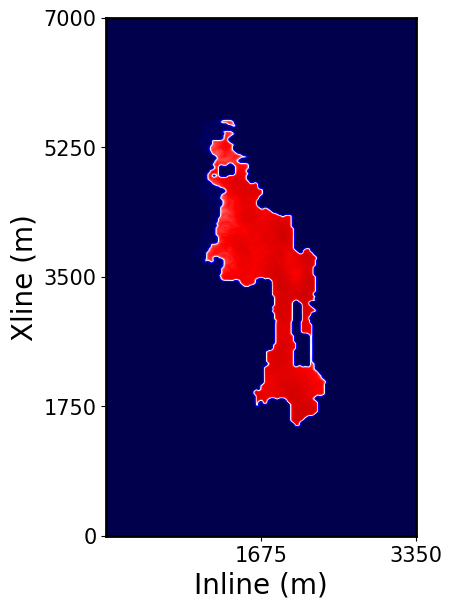

In [38]:
for i in range(nl):
    print(f'plot layer No. {lyidx[i]}')    
    print(f'plot the reference CO2 plume:')
    fig,ax = plt.subplots(1,1,figsize=(4,8))
    ax.imshow(lmr[i].T,aspect=0.8,cmap='seismic',vmin=0,vmax=1,
              extent=(xa[0],xa[-1],ya[0],ya[-1]))
    ax.set_xlabel('Inline (m)', fontsize=20)
    ax.set_ylabel('Xline (m)', fontsize=20)
    ytick = np.linspace(0,7000,5,dtype=np.int16) 
    xtick = np.linspace(0,xa[-1],3,dtype=np.int16)
    ax.set_xticks(xtick[1:])
    ax.set_xticklabels([f'{k}' for k in xtick[1:]],fontsize=15)
    ax.set_yticks(ytick)
    ax.set_yticklabels([f'{k}' for k in ytick],fontsize=15)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    BB = ax.get_position()
    BB.y0 = 0
    BB.x0 = -0.5
    BB.y1 = 8
    BB.x1 = 4
    fig.savefig(f'{outpath}/fig8_mask_ref_{lyidx[i]}.png',dpi=300,bbox_inches=BB)

## display the predicted CO2 distribution

plot the pred CO2 plume from 2010_b01_t10:
plot the pred CO2 plume from 2010_b01_t11:
plot the pred CO2 plume from 2010_b10_t10:
plot the pred CO2 plume from 2010_b10_t11:


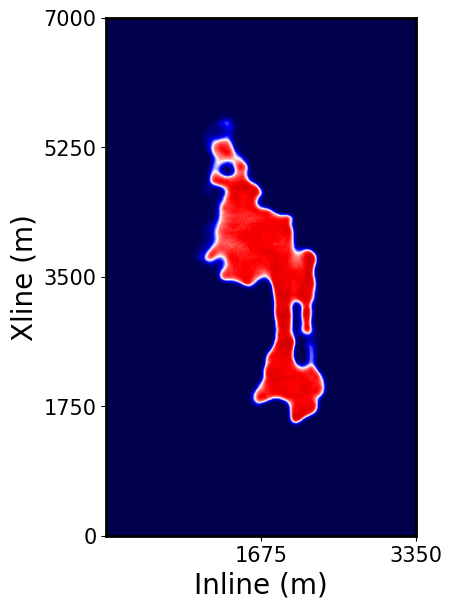

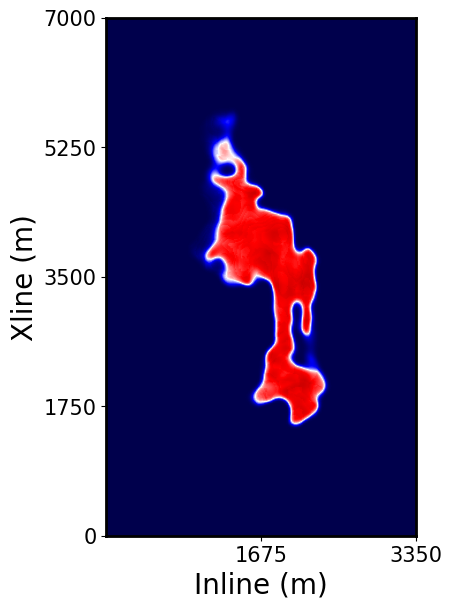

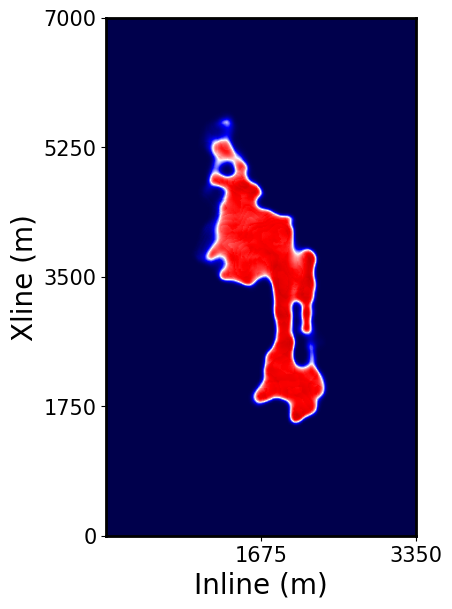

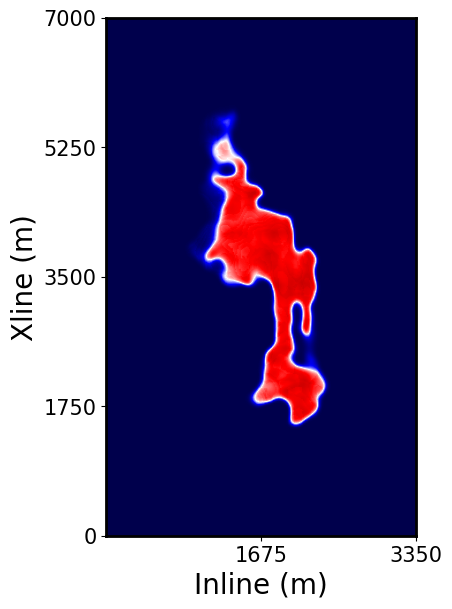

In [39]:
for i in range(nfn):   
    for j in range(len(lyidx)):            
        print(f'plot the pred CO2 plume from {path2010[i]}:')
        fig,ax = plt.subplots(1,1,figsize=(4,8))
        ax.imshow(lmp[i,j].T,aspect=0.8,cmap='seismic',vmin=0,vmax=1,
                  extent=(xa[0],xa[-1],ya[0],ya[-1]))
        ax.set_ylabel('Xline (m)', fontsize=20)
        ax.set_xlabel('Inline (m)', fontsize=20)
        ytick = np.linspace(0,7000,5,dtype=np.int16) 
        xtick = np.linspace(0,xa[-1],3,dtype=np.int16)
        ax.set_xticks(xtick[1:])
        ax.set_xticklabels([f'{k}' for k in xtick[1:]],fontsize=15)
        ax.set_yticks(ytick)
        ax.set_yticklabels([f'{k}' for k in ytick],fontsize=15)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        BB = ax.get_position()
        BB.y0 = 0
        BB.x0 = -0.5
        BB.y1 = 8
        BB.x1 = 4
        fig.savefig(f'{outpath}/fig8_mask_pred_{path2010[i]}_{lyidx[j]}.png',dpi=300,bbox_inches=BB)

# Different dataset testing for different layers in Figure 9

## load the predictions and traveltime interface information

In [40]:
# define path and fn for NN tests
path = testpath
# testing datasets
yearlist = ['1999_b01_t01','2001_b01_t01',
            '2004_b01_t07','2006_b01_t07',
            '2008_b01_t08','2010_b10_t10']
ny = len(yearlist)
fn_tsMask = f'tsMask.dat'
# define new lyidx
lyidx = [0,4,8]
nl = len(lyidx)

In [41]:
# readin reference dataset information
xydfn = f'{dir_co2}/10p10/data/10p10nea.sgy'     #add your path
Dr = dataload(fn=xydfn)
_,xd,yd,td = Dr.getdata()
DD = (Dr.nx,Dr.ny,Dr.nt)

Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)


In [42]:
mp = []
for i in range(ny):
    mask= np.fromfile(f'{path}/{yearlist[i]}/test/{fn_tsMask}',dtype=np.float32)   #add your path
    mp.append(np.reshape(mask,DD))

## calculate different layer predicted CO2 plume

In [43]:
# derive certain layer of time-lapse data
Lmp = []
for y in range(ny):
    lmp = np.zeros((nl,DD[0],DD[1]),dtype=np.float32)
    for i,j in product(range(DD[0]),range(DD[1])):
        for c,k in enumerate(lyidx):
            Ttk = T_top[N-k-1,i,j]
            Tbk = T_base[N-k-1,i,j]
            mk = (td>Ttk) * (td<Tbk)
            if np.sum(mk) == 0:
                ind = np.argmin(np.abs(td-Ttk)+np.abs(td-Tbk))
                mk[ind] = True
            lmp[c,i,j] = np.mean(mp[y][i,j,mk])
    Lmp.append(lmp)

## display the combined results

In [44]:
[nI,nX] = Lmp[0][0].shape

In [45]:
# combine the objective layer (0,4,8) in different year result together
MC = np.zeros((ny*nI,nl*nX),dtype=np.float32)
for y in range(ny):
    for i in range(nl):
        print(f'combine layer No. {lyidx[i]} at year {yearlist[y]}')
        MC[y*nI:(y+1)*nI,i*nX:(i+1)*nX] = Lmp[y][i]

combine layer No. 0 at year 1999_b01_t01
combine layer No. 4 at year 1999_b01_t01
combine layer No. 8 at year 1999_b01_t01
combine layer No. 0 at year 2001_b01_t01
combine layer No. 4 at year 2001_b01_t01
combine layer No. 8 at year 2001_b01_t01
combine layer No. 0 at year 2004_b01_t07
combine layer No. 4 at year 2004_b01_t07
combine layer No. 8 at year 2004_b01_t07
combine layer No. 0 at year 2006_b01_t07
combine layer No. 4 at year 2006_b01_t07
combine layer No. 8 at year 2006_b01_t07
combine layer No. 0 at year 2008_b01_t08
combine layer No. 4 at year 2008_b01_t08
combine layer No. 8 at year 2008_b01_t08
combine layer No. 0 at year 2010_b10_t10
combine layer No. 4 at year 2010_b10_t10
combine layer No. 8 at year 2010_b10_t10


In [46]:
tkny = 5
tknx = 3
ytick = np.linspace(0,ya[-1]*nl,(tkny-1)*len(lyidx)+1)
ykL = np.linspace(0,7000,tkny,dtype=np.int16)
ytickL = ykL
for i in range(nl-1):
    ytickL = np.concatenate((ytickL,ykL[1:]),axis=0)

xtick = np.linspace(0,xa[-1]*ny,(tknx-1)*len(yearlist)+1)
xkL = np.linspace(0,xa[-1],tknx,dtype=np.int16)
xtickL = xkL
for i in range(ny-1):
    xtickL = np.concatenate((xtickL,xkL[1:]),axis=0)

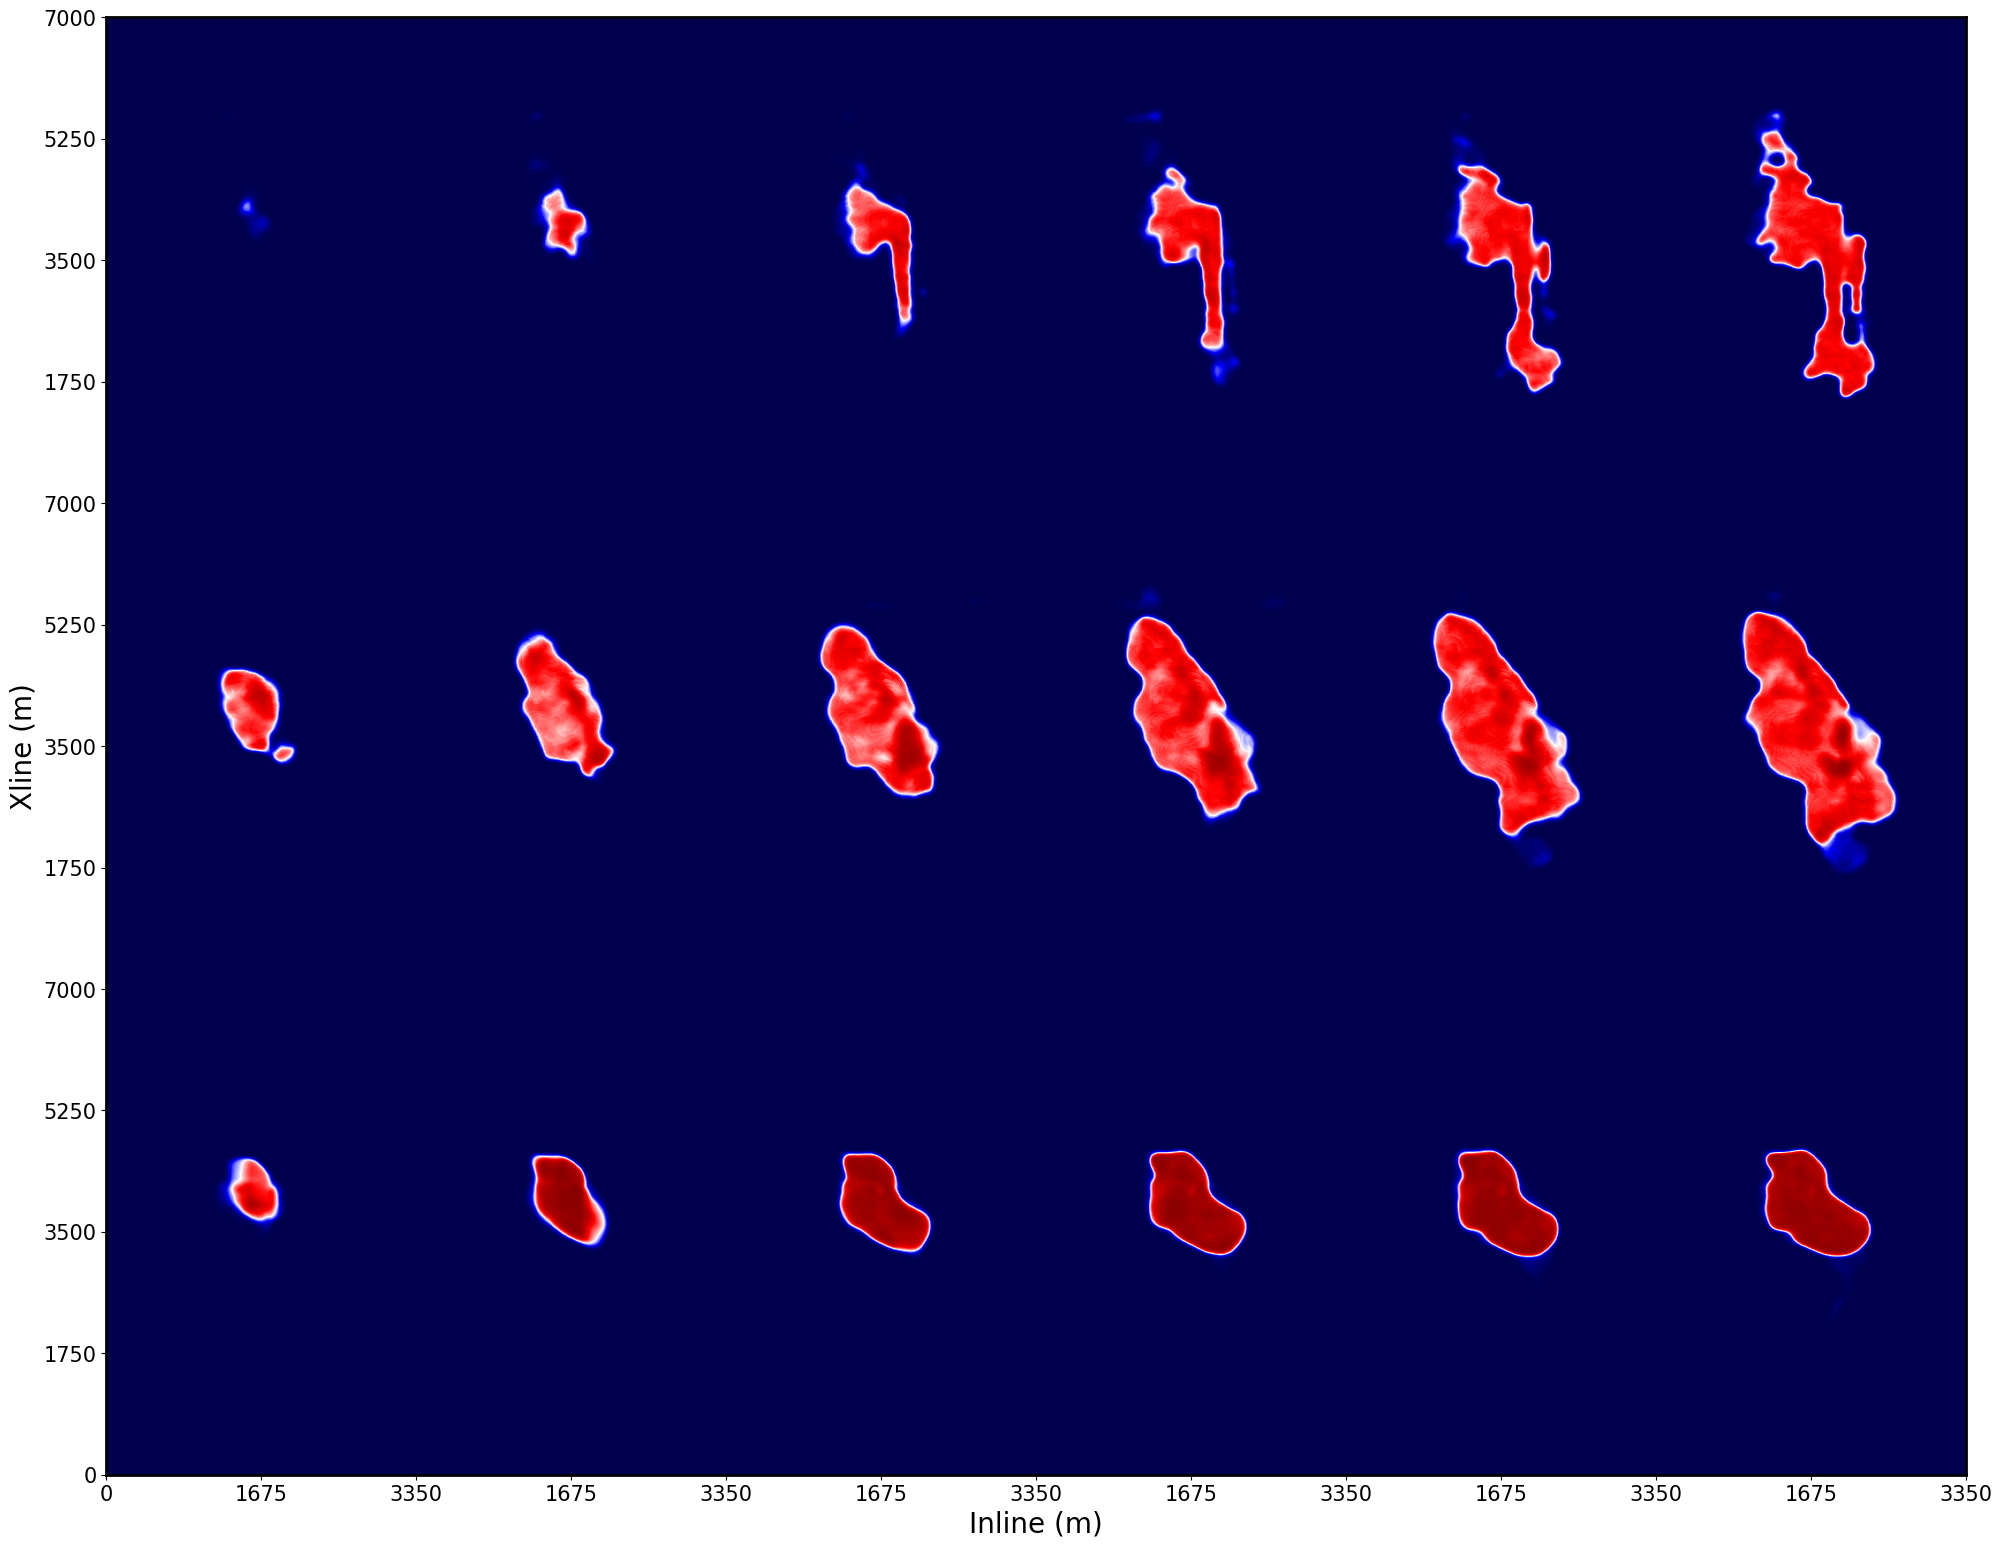

In [47]:
# plot the combined figure
fig,ax = plt.subplots(1,1,figsize=(4*ny,8*nl))
ax.imshow(MC.T,aspect=0.75,cmap='seismic',vmin=0,vmax=1,
          extent=(xa[0],xa[-1]*ny,ya[0],ya[-1]*nl))
ax.set_ylabel('Xline (m)', fontsize=20)
ax.set_xlabel('Inline (m)', fontsize=20)
ax.set_xticks(xtick)
ax.set_xticklabels([f'{i}' for i in xtickL],fontsize=15)
ax.set_yticks(ytick)
ax.set_yticklabels([f'{i}' for i in ytickL],fontsize=15)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
fig.savefig(f'{outpath}/fig9_mask_layer_year.png',dpi=300)

# Discussion 1: Analysis for NN interpretation standards in Figure 10

## display the baseline, time-lapse and labels for the inline section

In [48]:
# readin reference dataset information
xydfn = f'{dir_co2}/10p10/data/10p10nea.sgy'      #add your path
d0fn = f'{dir_co2}/94p10/data/94p10nea.sgy'        #add your path
Dr = dataload(fn=xydfn)
D0 = dataload(fn=d0fn)
dt,xd,yd,td = Dr.getdata()
d0,_,_,_ = D0.getdata()
DD = (Dr.nx,Dr.ny,Dr.nt)

Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)
Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)


In [49]:
xa = xd[:,0]-np.amin(xd[:,0])
ya = yd[0,:]-np.amin(yd[0,:])
ny = len(ya)
nt = len(td)

In [50]:
path_mask = f'/scratch/gilbreth/pate2126/DKP_new/resources/label/masks.dat'         #add your path
# readin CO2 mask
masks = np.fromfile(f'{path_mask}',dtype=np.float32)
masks = np.reshape(masks,tuple(DD))
path_pred = testpath

In [51]:
Inl = 130
Xnl = 245
Tsp = np.array([450,850])
dtI = dt[Inl,:,:]
d0I = d0[Inl,:,:]
mI = masks[Inl,:,:]

In [52]:
Ttop = Tsp-128
Tbot = Tsp+128
Xlef = Xnl-64
Xrig = Xnl+64

In [53]:
nytk = 6
nttk = 5
ytick = np.linspace(0,ny-1,nytk)
ttick = np.linspace(0,nt-1,nttk)
ykL = np.linspace(0,7000,nytk,dtype=np.int16)
tkL = np.linspace(0,2000,nttk,dtype=np.int16)

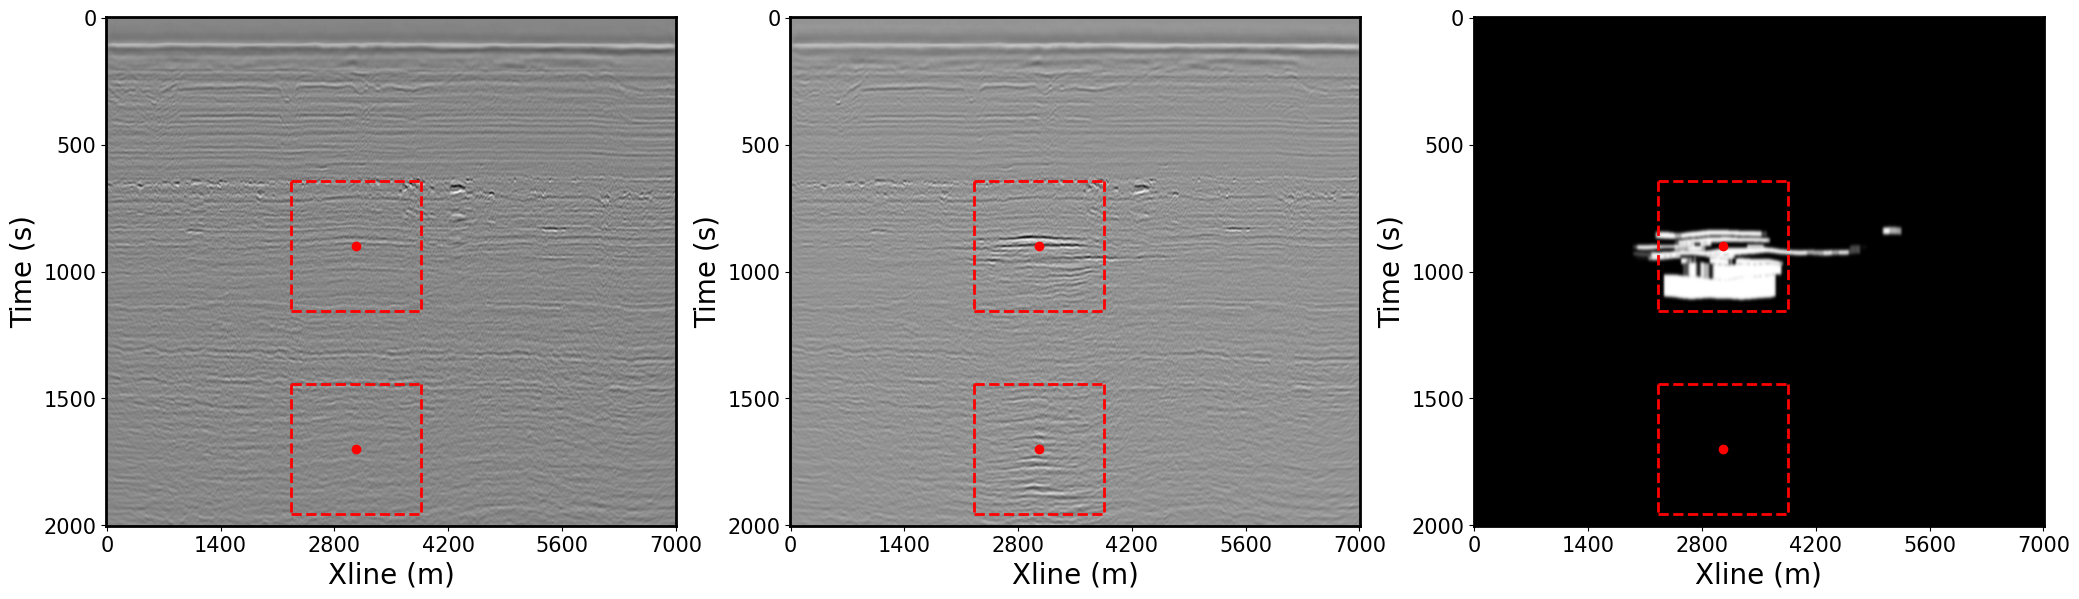

In [54]:
fig,ax = plt.subplots(1,3,figsize=(25,8))
ax[0].imshow(d0I.T,aspect=0.5,cmap='gray')
ax[1].imshow(dtI.T,aspect=0.5,cmap='gray')
ax[2].imshow(mI.T,aspect=0.5,cmap='gray')
for i in range(3):
    # plot the cube centers and lines
    ax[i].plot(Xnl,Tsp[0],'ro',markersize=6)
    ax[i].plot(Xnl,Tsp[1],'ro',markersize=6)
    ax[i].plot([Xlef,Xlef],[Ttop[0],Tbot[0]],'r--',linewidth=2)
    ax[i].plot([Xlef,Xlef],[Ttop[1],Tbot[1]],'r--',linewidth=2)
    ax[i].plot([Xrig,Xrig],[Ttop[0],Tbot[0]],'r--',linewidth=2)
    ax[i].plot([Xrig,Xrig],[Ttop[1],Tbot[1]],'r--',linewidth=2)
    ax[i].plot([Xlef,Xrig],[Ttop[0],Ttop[0]],'r--',linewidth=2)
    ax[i].plot([Xlef,Xrig],[Ttop[1],Ttop[1]],'r--',linewidth=2)
    ax[i].plot([Xlef,Xrig],[Tbot[0],Tbot[0]],'r--',linewidth=2)
    ax[i].plot([Xlef,Xrig],[Tbot[1],Tbot[1]],'r--',linewidth=2)
    # plot the labels and ticks
    ax[i].set_ylabel('Time (s)', fontsize=20)
    ax[i].set_xlabel('Xline (m)', fontsize=20)
    ax[i].set_xticks(ytick)
    ax[i].set_xticklabels([f'{j}' for j in ykL],fontsize=15)
    ax[i].set_yticks(ttick)
    ax[i].set_yticklabels([f'{j}' for j in tkL],fontsize=15)
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
fig.savefig(f'{outpath}/figD1-1_R0tM.png',dpi=300)

## display different cubes

### define the cube display function (without axis)

In [55]:
# define 3D plot function
def show3D(md, ax=None, xyz=None, xyzi=(0,0,0), ea=(30,-45), clip=1, rcstride=(1,1), clim=None, tl=None):
    r'''plot 3D cube image:
        md-3-D data volume (3darray, float, (n1,n2,n3))
        ax-plot axis (None or a given ax)
        xyz-3-D axes coordinates (list, 1darray, (3,))
        xyzi-position of three slicing image indices (tuple, int, (3,))
        ea-viewing angle (tuple, float, (2,))
        clip-image clipping (scalar, float, <1)
        rcstride-2-D plotting stride (tuple, int, (2,))
        clim-colorbar range (None or tuple, int, (2,)): if it is not None, clip is overwritten'''
    
    # get default coordinates
    nx,ny,nz = md.shape
    if xyz is None:
        xyz = [np.arange(nx),np.arange(ny),np.arange(nz)]
    # slice zero index image along each dimension
    mx = md[xyzi[0],:,:].transpose()
    my = md[:,xyzi[1],:].transpose()
    mz = md[:,:,xyzi[2]].transpose()
    MIN = min([np.amin(mx),np.amin(my),np.amin(mz)])
    MAX = max([np.amax(mx),np.amax(my),np.amax(mz)])
    if clim is None:
        cN = pcl.Normalize(vmin=MIN*clip, vmax=MAX*clip)
        rg = [MIN*clip,(MAX-MIN)*clip]
    else:
        cN = pcl.Normalize(vmin=clim[0], vmax=clim[1])
        rg = [clim[0],clim[1]-clim[0]]
    # plot the model
    if ax is None:
        fig = plt.figure(figsize=plt.figaspect(0.8))
        ax = fig.add_subplot(1,1,1,projection='3d')
    else:
        fig = None
    
    # plot the indicator line
    xi = xyz[0][xyzi[0]]
    yi = xyz[1][xyzi[1]]
    zi = xyz[2][xyzi[2]]
    ax.plot([xi,xi],[xyz[1][0],xyz[1][0]],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xi,xi],[xyz[1][0],xyz[1][-1]],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[yi,yi],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[yi,yi],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[xyz[1][0],xyz[1][0]],[zi,zi],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[xyz[1][0],xyz[1][-1]],[zi,zi],'r-',linewidth=2,zorder=10)
    
    # plot the three surfaces
    ax = slice_show(ax, mz, xyz, 0, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, mx, xyz, 1, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, my, xyz, 2, rg=rg, rcstride=rcstride)
    
    # set the axes
    ax.view_init(elev=ea[0],azim=ea[1])
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.axis('off')

    return fig

def slice_show(ax, ms, xyz, od, rg=None, offset=0, rcstride=(10,10)):
    r'''show specific slice of model'''
    
    if rg is None:
        shift = np.amin(ms)
        normalizer = np.amax(ms)-shift
    else:
        shift = rg[0]
        normalizer = rg[1]
    if normalizer == 0:
        msN = np.zeros_like(ms)+0.5
    else:
        msN = (ms-shift)/normalizer
    colors = plt.cm.gray(msN)
    if od == 0:
        [X,Y] = np.meshgrid(xyz[0],xyz[1])
        Z = np.zeros_like(X)+xyz[2][0]+offset
    if od == 1:
        [Y,Z] = np.meshgrid(xyz[1],xyz[2])
        X = np.zeros_like(Y)+xyz[0][0]+offset
    if od == 2:
        [X,Z] = np.meshgrid(xyz[0],xyz[2])
        Y = np.zeros_like(X)+xyz[1][0]+offset
    surf = ax.plot_surface(X, Y, Z, 
                           facecolors=colors, rstride=rcstride[0], cstride=rcstride[1], zorder=1)
    
    return ax

### display the original cubes

In [56]:
path_NNa = f'{analpath}/data/'

In [57]:
R0t_org = np.fromfile(f'{path_NNa}orgR0t.dat',dtype=np.float32)
R0t = np.reshape(R0t_org,(2,2,64,64,64))
pred_org = np.fromfile(f'{path_NNa}orgpred.dat',dtype=np.float32)
pm = np.reshape(pred_org,(2,64,64,64))

In [58]:
rm0 = masks[Inl-64:Inl+64:2,Xnl-64:Xnl+64:2,Tsp[0]-128:Tsp[0]+128:4]
rm1 = masks[Inl-64:Inl+64:2,Xnl-64:Xnl+64:2,Tsp[1]-128:Tsp[1]+128:4]
rm = np.stack((rm0,rm1))

In [59]:
ixtid = [32,32,32]

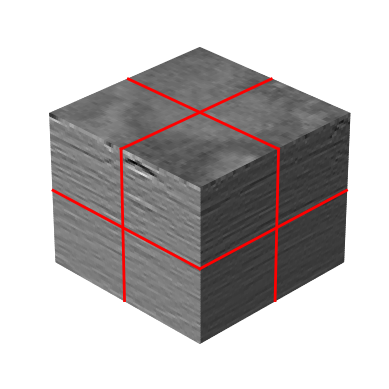

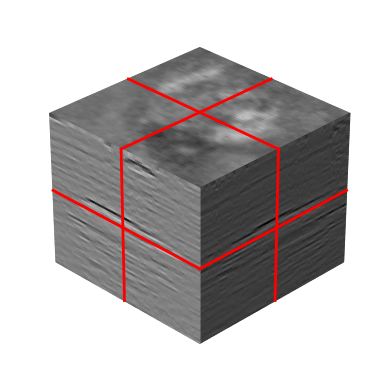

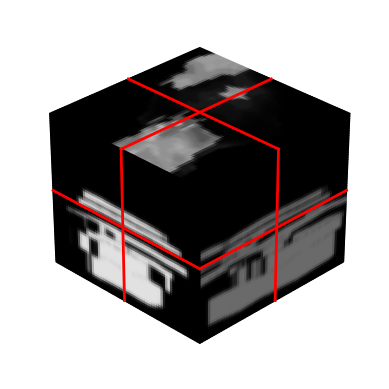

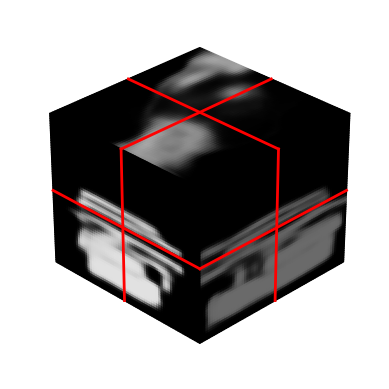

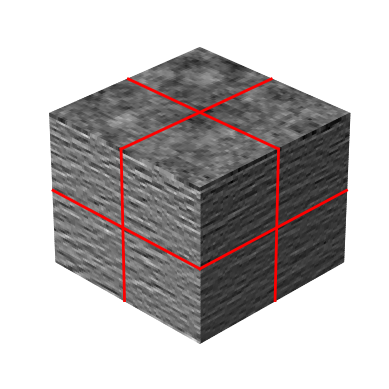

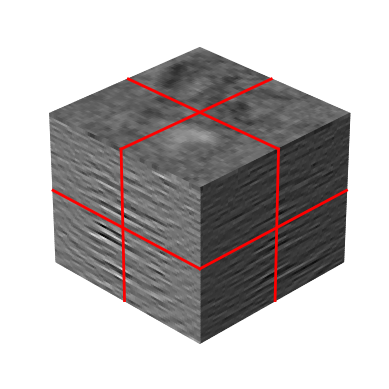

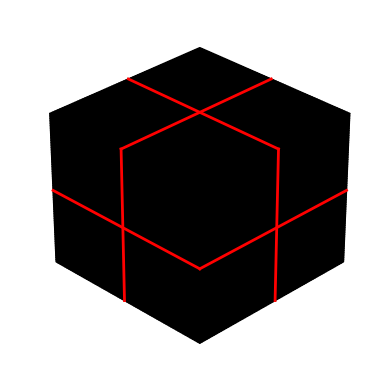

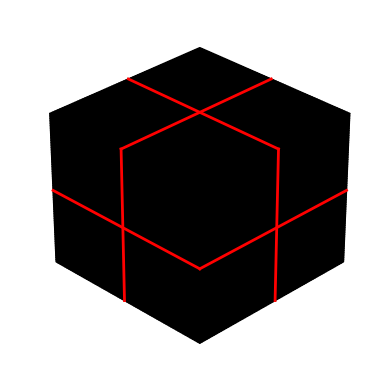

In [60]:
for i in range(2):
    fig = show3D(R0t[i,0],xyzi=ixtid)
    plt.show()
    fig.savefig(f'{outpath}/figD1-2_R0_{i}.png',dpi=300)
    fig = show3D(R0t[i,1],xyzi=ixtid)
    plt.show()
    fig.savefig(f'{outpath}/figD1-2_Rt_{i}.png',dpi=300)
    fig = show3D(rm[i],xyzi=ixtid,clim=[0,1])
    plt.show()
    fig.savefig(f'{outpath}/figD1-2_rm_{i}.png',dpi=300)
    fig = show3D(pm[i],xyzi=ixtid,clim=[0,1])
    plt.show()
    fig.savefig(f'{outpath}/figD1-2_pm_{i}.png',dpi=300)

### display the modified cubes

In [61]:
import os
# Define base path to your analysis directory
analpath = '/scratch/gilbreth/pate2126/DKP_new/NNpred3D/analysis'            #add your path
path_NNa0 = f'{analpath}/data_s0/'
os.makedirs(path_NNa0, exist_ok=True)
print("Path created:", path_NNa0)

✅ Path created: /scratch/gilbreth/pate2126/DKP_new/NNpred3D/analysis/data_s0/


In [62]:
s = np.fromfile(f'{path_NNa0}scale.dat',dtype=np.float32)
s = np.reshape(s,(64,64,64))
R0t_test = np.fromfile(f'{path_NNa0}testR0t.dat',dtype=np.float32)
R0t = np.reshape(R0t_test,(2,2,64,64,64))
pred_test = np.fromfile(f'{path_NNa0}testpred.dat',dtype=np.float32)
pm = np.reshape(pred_test,(2,64,64,64))

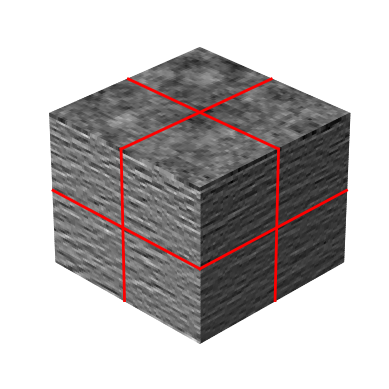

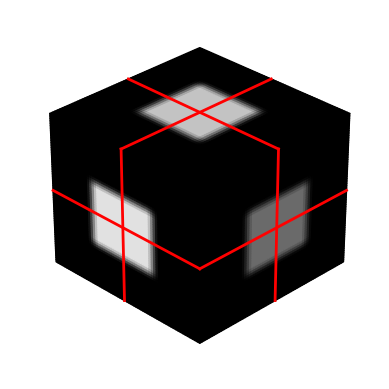

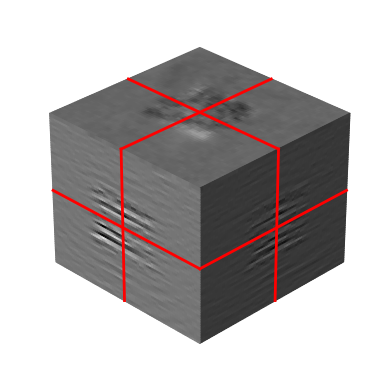

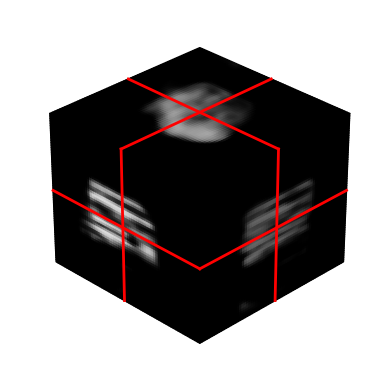

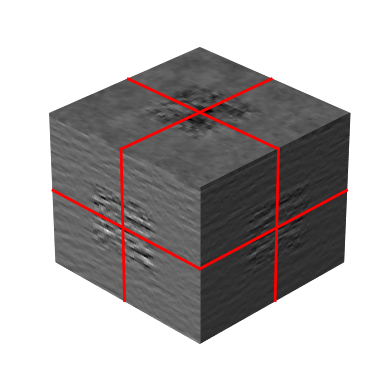

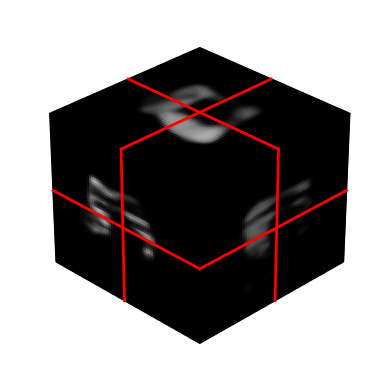

In [63]:
for i in range(2):
    if i == 0:
        fig = show3D(R0t[i,0],xyzi=ixtid)
        plt.show()
        fig.savefig(f'{outpath}/figD1-3_R0.png',dpi=300)
        fig = show3D(s,xyzi=ixtid)
        plt.show()
        fig.savefig(f'{outpath}/figD1-3_s.png',dpi=300)
    fig = show3D(R0t[i,1],xyzi=ixtid)
    plt.show()
    fig.savefig(f'{outpath}/figD1-3_Rt_{i}.png',dpi=300)
    fig = show3D(pm[i],xyzi=ixtid,clim=[0,1])
    plt.show()
    fig.savefig(f'{outpath}/figD1-3_pm_{i}.png',dpi=300)

# Discussion: 2D vs 3D with sparse labels (3D part)

## Readin data and reference masks in 3D

In [77]:
# readin reference dataset information
xydfn = f'{dir_co2}/10p10/data/10p10nea.sgy'           #add your path
Dr = dataload(fn=xydfn)
dt,xd,yd,td = Dr.getdata()
DD = (Dr.nx,Dr.ny,Dr.nt)

Total trace number: 150909
Sample number along each trace: 1001
Sampling interval along each trace: 0.002 s
data arrangement: 269 (number of ensembles) x 561 (trace number per ensemble) x 1001 (sample number per trace)


In [78]:
path_mask = f'/scratch/gilbreth/pate2126/DKP_new/resources/label/masks.dat'       #add your path
# readin CO2 mask
masks = np.fromfile(f'{path_mask}',dtype=np.float32)
masks = np.reshape(masks,tuple(DD))
path_pred = testpath

In [79]:
xa = xd[:,0]-np.amin(xd[:,0])
ya = yd[0,:]-np.amin(yd[0,:])
ta = td

## Display the interpreted slices (find the matlab code)

## display 3D training patch samples in Figure D2-4

### define sparse 3D and full 3D plotting functions respectively

In [80]:
def patch3D(mask,weight,idxy=None,rcstride=[1,1],ea=[30,-45],rg=[0,1],alpha0=0.5):
    r'''
    display the sparese 2D labels in their position for a label cube
        mask--3d numpy array (rs)
        weight--3d numpy array (rs)
    '''
    rs = mask.shape
    xa = np.arange(rs[0])
    ya = np.arange(rs[1])
    ta = np.arange(rs[2])
    
    ix = np.sum(weight,axis=(1,2))
    ix = np.squeeze(np.argwhere(np.amax(ix)==ix))
    iy = np.sum(weight,axis=(0,2))
    iy = np.squeeze(np.argwhere(np.amax(iy)==iy))
    
    fig = plt.figure(figsize=plt.figaspect(0.8))
    ax = fig.add_subplot(1,1,1,projection='3d')
    [Y,Z] = np.meshgrid(ya,ta)
    for k,i in enumerate(ix):
        ms = mask[i,:,:].T
        if rg is None:
            shift = np.amin(ms)
            normalizer = np.amax(ms)-shift
        else:
            shift = rg[0]
            normalizer = rg[1]
        if normalizer == 0:
            msN = np.zeros_like(ms)+0.5
        else:
            msN = (ms-shift)/normalizer
        colors = plt.cm.gray(msN)
        X = np.zeros_like(Y)+xa[i]
        if idxy != None:
            if idxy[0] == i:
                alpha = alpha0
            else:
                alpha = alpha0*0.5
        else:
            alpha = alpha0
        surf = ax.plot_surface(X, Y, Z, 
                               facecolors=colors, alpha=alpha, 
                               rstride=rcstride[0], cstride=rcstride[1], 
                               zorder=1, linewidth=0, antialiased=True)
    [X,Z] = np.meshgrid(xa,ta)
    for k,i in enumerate(iy):
        ms = mask[:,i,:].T
        if rg is None:
            shift = np.amin(ms)
            normalizer = np.amax(ms)-shift
        else:
            shift = rg[0]
            normalizer = rg[1]
        if normalizer == 0:
            msN = np.zeros_like(ms)+0.5
        else:
            msN = (ms-shift)/normalizer
        colors = plt.cm.gray(msN)
        Y = np.zeros_like(X)+ya[i]
        if idxy != None:
            if idxy[1] == i:
                alpha = alpha0
            else:
                alpha = alpha0*0.5
        else:
            alpha = alpha0
        surf = ax.plot_surface(X, Y, Z,
                               facecolors=colors, alpha=alpha, 
                               rstride=rcstride[0], cstride=rcstride[1], 
                               zorder=1, linewidth=0, antialiased=True)
    # set the axes
    ax.view_init(elev=ea[0],azim=ea[1])
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.axis('off')
    
    return ix[-1],iy[0],fig

In [81]:
# define 3D plot function
def show3D(md, ax=None, xyz=None, xyzi=(0,0,0), ea=(30,-45), clip=1, rcstride=(1,1), clim=None, tl=None):
    r'''plot 3D cube image:
        md-3-D data volume (3darray, float, (n1,n2,n3))
        ax-plot axis (None or a given ax)
        xyz-3-D axes coordinates (list, 1darray, (3,))
        xyzi-position of three slicing image indices (tuple, int, (3,))
        ea-viewing angle (tuple, float, (2,))
        clip-image clipping (scalar, float, <1)
        rcstride-2-D plotting stride (tuple, int, (2,))
        clim-colorbar range (None or tuple, int, (2,)): if it is not None, clip is overwritten'''
    
    # get default coordinates
    nx,ny,nz = md.shape
    if xyz is None:
        xyz = [np.arange(nx),np.arange(ny),np.arange(nz)]
    # slice zero index image along each dimension
    mx = md[xyzi[0],:,:].transpose()
    my = md[:,xyzi[1],:].transpose()
    mz = md[:,:,xyzi[2]].transpose()
    MIN = min([np.amin(mx),np.amin(my),np.amin(mz)])
    MAX = max([np.amax(mx),np.amax(my),np.amax(mz)])
    if clim is None:
        cN = pcl.Normalize(vmin=MIN*clip, vmax=MAX*clip)
        rg = [MIN*clip,(MAX-MIN)*clip]
    else:
        cN = pcl.Normalize(vmin=clim[0], vmax=clim[1])
        rg = [clim[0],clim[1]-clim[0]]
    # plot the model
    if ax is None:
        fig = plt.figure(figsize=plt.figaspect(0.8))
        ax = fig.add_subplot(1,1,1,projection='3d')
    else:
        fig = None
    
    # plot the indicator line
    xi = xyz[0][xyzi[0]]
    yi = xyz[1][xyzi[1]]
    zi = xyz[2][xyzi[2]]
    ax.plot([xi,xi],[xyz[1][0],xyz[1][0]],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xi,xi],[xyz[1][0],xyz[1][-1]],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[yi,yi],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[yi,yi],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[xyz[1][0],xyz[1][0]],[zi,zi],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[xyz[1][0],xyz[1][-1]],[zi,zi],'r-',linewidth=2,zorder=10)
    
    # plot the three surfaces
    ax = slice_show(ax, mz, xyz, 0, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, mx, xyz, 1, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, my, xyz, 2, rg=rg, rcstride=rcstride)
    
    # set the axes
    ax.view_init(elev=ea[0],azim=ea[1])
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.axis('off')

    return fig

def slice_show(ax, ms, xyz, od, rg=None, offset=0, rcstride=(10,10)):
    r'''show specific slice of model'''
    
    if rg is None:
        shift = np.amin(ms)
        normalizer = np.amax(ms)-shift
    else:
        shift = rg[0]
        normalizer = rg[1]
    if normalizer == 0:
        msN = np.zeros_like(ms)+0.5
    else:
        msN = (ms-shift)/normalizer
    colors = plt.cm.gray(msN)
    if od == 0:
        [X,Y] = np.meshgrid(xyz[0],xyz[1])
        Z = np.zeros_like(X)+xyz[2][0]+offset
    if od == 1:
        [Y,Z] = np.meshgrid(xyz[1],xyz[2])
        X = np.zeros_like(Y)+xyz[0][0]+offset
    if od == 2:
        [X,Z] = np.meshgrid(xyz[0],xyz[2])
        Y = np.zeros_like(X)+xyz[1][0]+offset
    surf = ax.plot_surface(X, Y, Z, 
                           facecolors=colors, rstride=rcstride[0], cstride=rcstride[1], zorder=1)
    
    return ax

### load the training dataset and trained network

In [82]:
# dataset information file names
pmf = 'pm_info.json'
pdf = 'patch_info'
pdfap = '.csv'
# load training dataset
root = train_sparselabel
train = dataset_patch(root,pmf,f'{pdf}_train{pdfap}',sliceitp=True)
Ntrain = len(train)

In [83]:
train_id = [214,1357]
rs = (64,64,64)

In [84]:
# network path
path_bestnet = f'/scratch/gilbreth/pate2126/DKP_new/NNpred3D/train_sparselabel/co2_identify_best_sps.pt'      #add your path
# load the network
networktest = CO2mask()
networktest.load_state_dict(torch.load(path_bestnet,map_location=torch.device('cpu')))
networktest = networktest.eval()

/tmp/ipykernel_2100016/3722198958.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  networktest.load_state_dict(torch.load(path_bestnet,map_location=torch.device('cpu')))


[214, 1357]


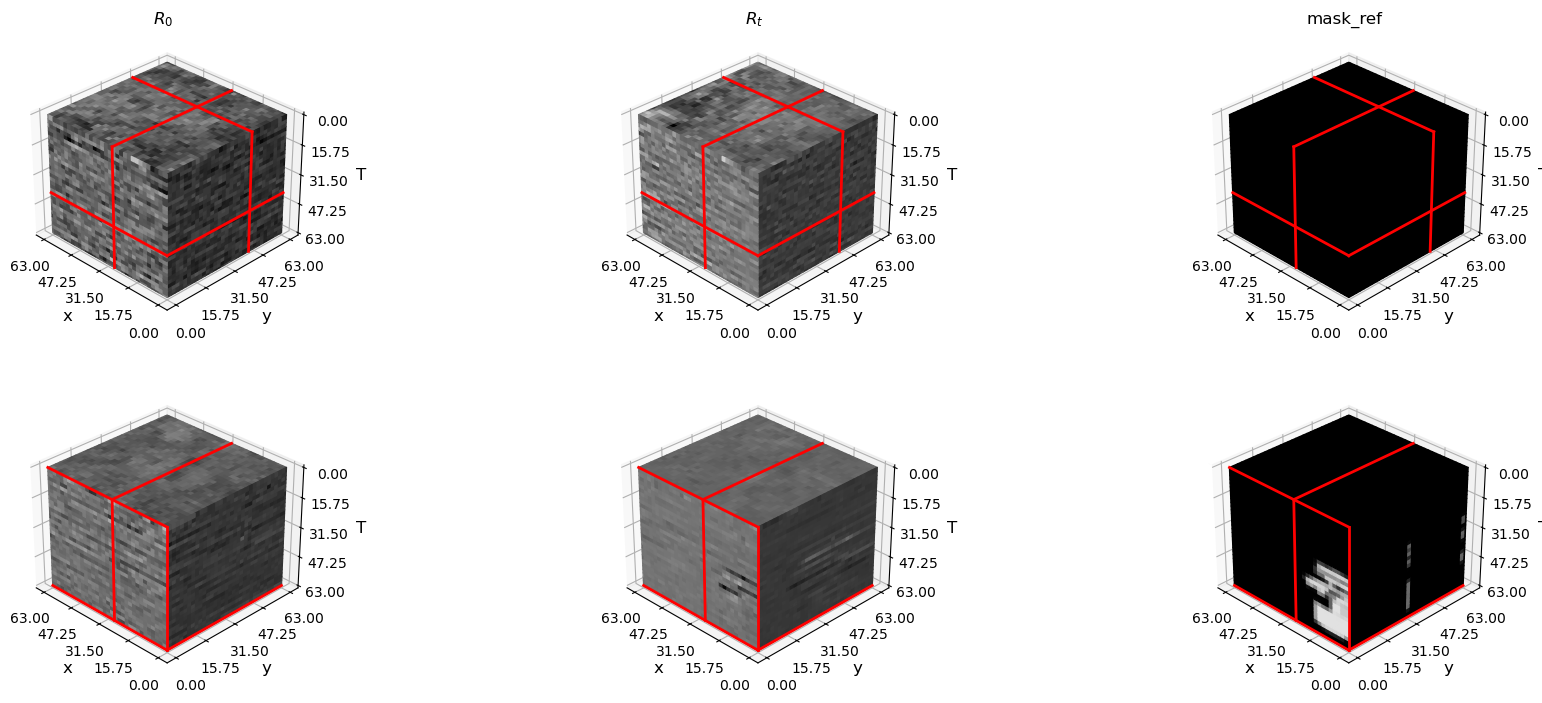

In [85]:
print(train_id)
pst = patch_show(train,train_id)
pst.ixtid = [[28, 44, 41], [28, 0, 63]]
pst.view3d(rcstride=(2,2))

In [86]:
pst.ixtid

[[28, 44, 41], [28, 0, 63]]

### get the sampled patch and make predictions

In [87]:
R0 = []
Rt = []
M = []
Mp = []
W = []
iz = []
for i in range(len(train_id)):
    R0t,m,w,_ = train.__getitem__(train_id[i])
    mp = networktest(R0t.unsqueeze(0))
    Mp.append(mp[0,0].detach().numpy())
    R0.append(R0t[0].numpy())
    Rt.append(R0t[1].numpy())
    M.append(m[0].numpy())
    W.append(w[0].numpy())

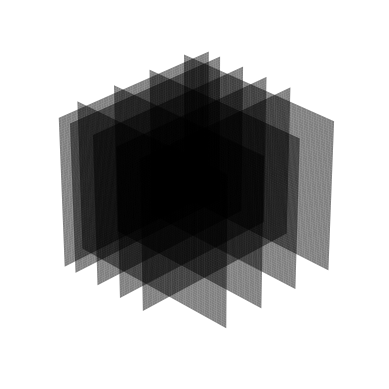

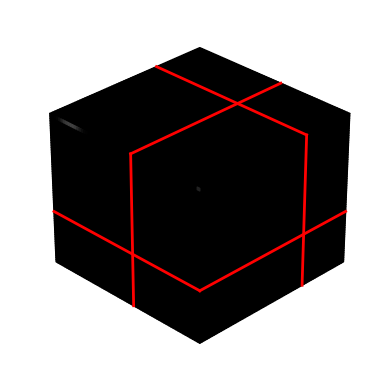

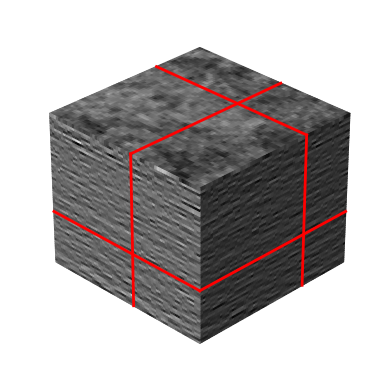

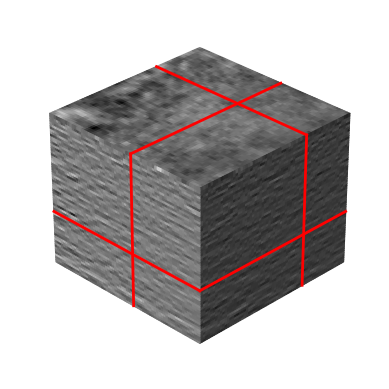

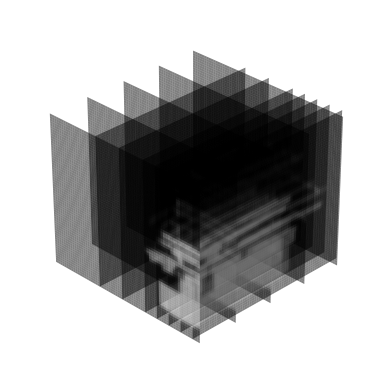

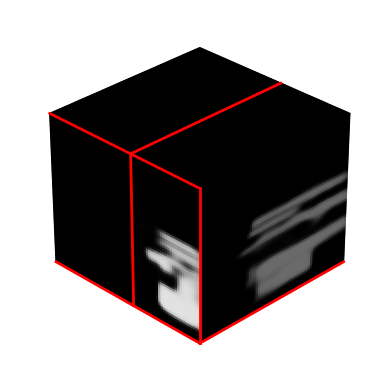

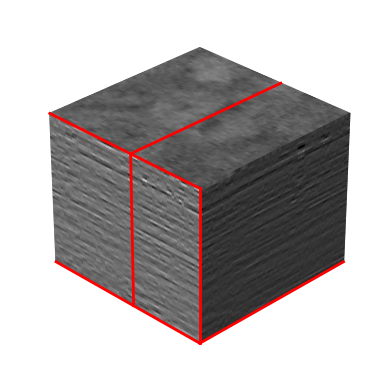

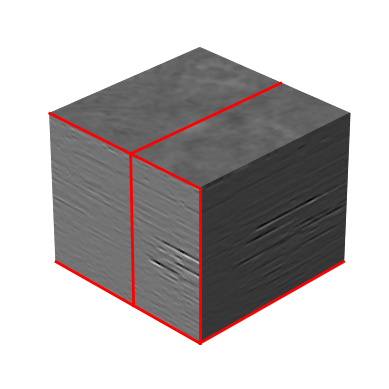

In [88]:
for i in range(len(train_id)):
    # print label
    ix0,iy0,fig = patch3D(M[i],W[i])
    plt.show()
    fig.savefig(f'{outpath}/figD2-4_sps_train_label_{i}.png',dpi=300)
    # print pred
    fig = show3D(Mp[i],xyzi=pst.ixtid[i])
    plt.show()
    fig.savefig(f'{outpath}/figD2-4_sps_train_pred_{i}.png',dpi=300)
    # print R0
    fig = show3D(R0[i],xyzi=pst.ixtid[i])
    plt.show()
    fig.savefig(f'{outpath}/figD2-4_sps_train_R0_{i}.png',dpi=300)
    # print Rt
    fig = show3D(Rt[i],xyzi=pst.ixtid[i])
    plt.show()
    fig.savefig(f'{outpath}/figD2-4_sps_train_Rt_{i}.png',dpi=300)

## display test results

### define the 3D ploting function

In [89]:
# define 3D plot function
def show3D(md, ax=None, xyz=None, xyzi=(0,0,0), ea=(30,-25), clip=1, rcstride=(1,1), clim=None, tl=None):
    r'''plot 3D cube image:
        md-3-D data volume (3darray, float, (n1,n2,n3))
        ax-plot axis (None or a given ax)
        xyz-3-D axes coordinates (list, 1darray, (3,))
        xyzi-position of three slicing image indices (tuple, int, (3,))
        ea-viewing angle (tuple, float, (2,))
        clip-image clipping (scalar, float, <1)
        rcstride-2-D plotting stride (tuple, int, (2,))
        clim-colorbar range (None or tuple, int, (2,)): if it is not None, clip is overwritten'''
    
    # get default coordinates
    nx,ny,nz = md.shape
    if xyz is None:
        xyz = [np.arange(nx),np.arange(ny),np.arange(nz)]
    # slice zero index image along each dimension
    mx = md[xyzi[0],:,:].transpose()
    my = md[:,xyzi[1],:].transpose()
    mz = md[:,:,xyzi[2]].transpose()
    MIN = min([np.amin(mx),np.amin(my),np.amin(mz)])
    MAX = max([np.amax(mx),np.amax(my),np.amax(mz)])
    if clim is None:
        cN = pcl.Normalize(vmin=MIN*clip, vmax=MAX*clip)
        rg = [MIN*clip,(MAX-MIN)*clip]
    else:
        cN = pcl.Normalize(vmin=clim[0], vmax=clim[1])
        rg = [clim[0],clim[1]-clim[0]]
    # plot the model
    if ax is None:
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(1,1,1,projection='3d')
    else:
        fig = None
    
    # plot the indicator line
    xi = xyz[0][xyzi[0]]
    yi = xyz[1][xyzi[1]]
    zi = xyz[2][xyzi[2]]
    ax.plot([xi,xi],[xyz[1][0],xyz[1][0]],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xi,xi],[xyz[1][0],xyz[1][-1]],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[yi,yi],[xyz[2][0],xyz[2][-1]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[yi,yi],[xyz[2][0],xyz[2][0]],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][-1]],[xyz[1][0],xyz[1][0]],[zi,zi],'r-',linewidth=2,zorder=10)
    ax.plot([xyz[0][0],xyz[0][0]],[xyz[1][0],xyz[1][-1]],[zi,zi],'r-',linewidth=2,zorder=10)
    
    # plot the three surfaces
    ax = slice_show(ax, mz, xyz, 0, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, mx, xyz, 1, rg=rg, rcstride=rcstride)
    ax = slice_show(ax, my, xyz, 2, rg=rg, rcstride=rcstride)
    
    # set the axes
    ax.set_xticks(np.linspace(0,4000,3))
    ax.set_yticks(np.linspace(0,8000,5))
    ax.set_zticks(np.linspace(0,2,5))
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(15)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(15) 
    for tick in ax.zaxis.get_major_ticks():
        tick.label1.set_fontsize(15) 
    if tl is not None:
        ax.set_title(tl,fontsize=15)
    ax.view_init(elev=ea[0],azim=ea[1])
    ax.invert_zaxis()
    ax.invert_xaxis()
    ax.set_xlabel('Inline (m)',fontsize=20,labelpad=20)
    ax.set_ylabel('Xline (m)',fontsize=20,labelpad=20)
    ax.set_zlabel('T (s)',fontsize=20,labelpad=10)
    r'''
    if cb:
        plt.colorbar(cm.ScalarMappable(norm=cN, cmap='gray'))
    plt.show()
    '''
    return fig

def slice_show(ax, ms, xyz, od, rg=None, offset=0, rcstride=(10,10)):
    r'''show specific slice of model'''
    
    if rg is None:
        shift = np.amin(ms)
        normalizer = np.amax(ms)-shift
    else:
        shift = rg[0]
        normalizer = rg[1]
    if normalizer == 0:
        msN = np.zeros_like(ms)+0.5
    else:
        msN = (ms-shift)/normalizer
    colors = plt.cm.gray(msN)
    if od == 0:
        [X,Y] = np.meshgrid(xyz[0],xyz[1])
        Z = np.zeros_like(X)+xyz[2][0]+offset
    if od == 1:
        [Y,Z] = np.meshgrid(xyz[1],xyz[2])
        X = np.zeros_like(Y)+xyz[0][0]+offset
    if od == 2:
        [X,Z] = np.meshgrid(xyz[0],xyz[2])
        Y = np.zeros_like(X)+xyz[1][0]+offset
    surf = ax.plot_surface(X, Y, Z, 
                           facecolors=colors, rstride=rcstride[0], cstride=rcstride[1], zorder=1)
    
    return ax

In [90]:
# generate X,Y and Z
xm = np.amin(xd)
ym = np.amin(yd)
x = xd[:,0]-xm
y = yd[0,:]-ym
z = td
xyz = [x,y,z]

### plot 3D results

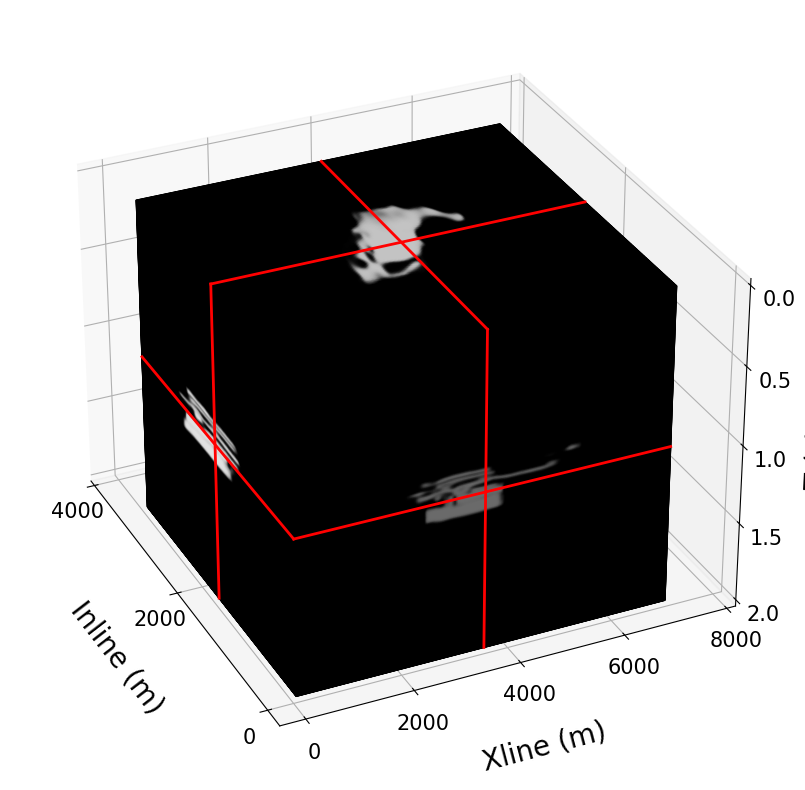

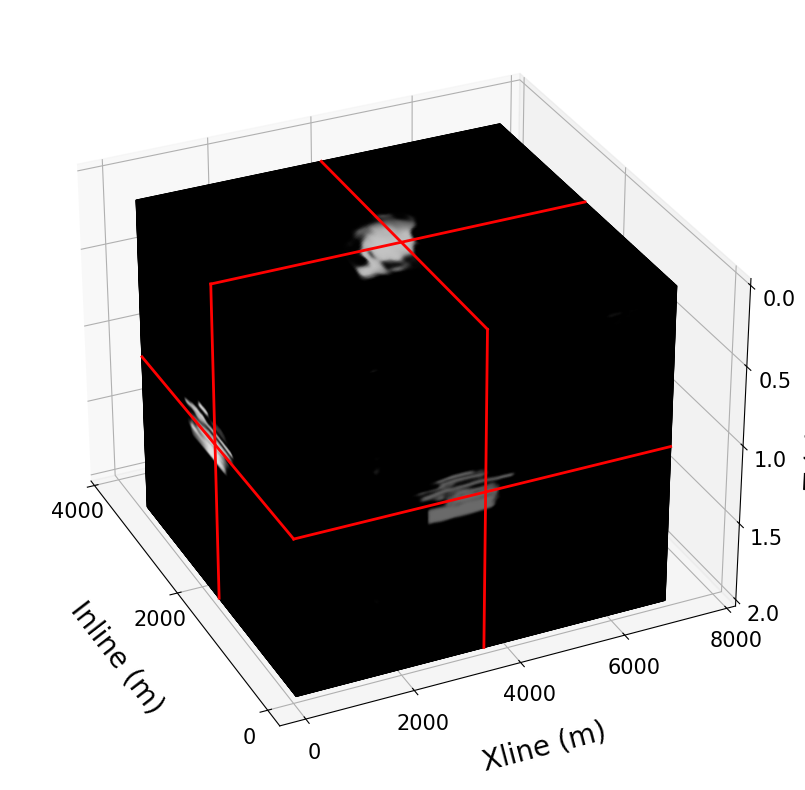

In [91]:
# two tests
year = ['2010_b01_t10','2004_b01_t07']
nyear = len(year)
Mask = []
for i in range(nyear):
    mask= np.fromfile(f'{path_pred}/{year[i]}/test/tsMask_sps.dat',dtype=np.float32)
    mask = np.reshape(mask,DD)
    Mask.append(mask)
    fig = show3D(mask,xyz=xyz,xyzi=(DD[0]//2,DD[1]//2,DD[2]//2),clim=[0,1])
    fig.savefig(f'{outpath}/figD2-5_mask_pred_{year[i]}.png',dpi=300)

### plot 2D layer results

In [92]:
N = 9 # number of CO2 layers
lyidx = [0]
nfn = nyear

In [93]:
# load the T_top and T_base
T_top = np.fromfile(f'../resources/label/T_top.dat',dtype=np.float64)
T_base = np.fromfile(f'../resources/label/T_base.dat',dtype=np.float64)
T_top = np.reshape(T_top,(N,DD[0],DD[1]))
T_base = np.reshape(T_base,(N,DD[0],DD[1]))

In [94]:
# derive certain layer of predictions
lmp = np.zeros((nfn,len(lyidx),DD[0],DD[1]),dtype=np.float32)
for i,j in product(range(DD[0]),range(DD[1])):
    for c,k in enumerate(lyidx):
        Ttk = T_top[N-k-1,i,j]
        Tbk = T_base[N-k-1,i,j]
        mk = (td>=Ttk) * (td<=Tbk)
        if np.sum(mk) == 0:
            continue
        for n in range(nfn):
            lmp[n,c,i,j] = np.mean(Mask[n][i,j,mk])    

plot the pred CO2 plume from test dataset 2010_b01_t10:
plot the pred CO2 plume from test dataset 2004_b01_t07:


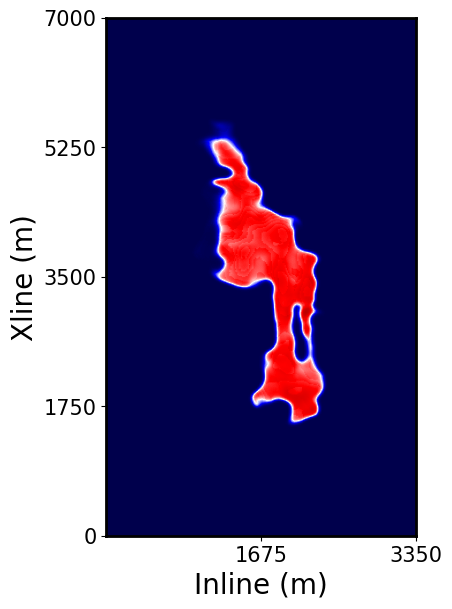

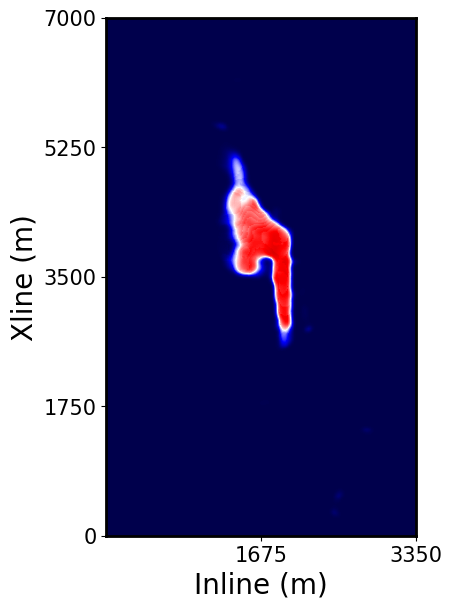

In [95]:
for i in range(nfn):   
    for j in range(len(lyidx)):                                                             
        print(f'plot the pred CO2 plume from test dataset {year[i]}:')
        fig,ax = plt.subplots(1,1,figsize=(4,8))
        ax.imshow(lmp[i,j].T,aspect=0.8,cmap='seismic',vmin=0,vmax=1,
                  extent=(xa[0],xa[-1],ya[0],ya[-1]))
        ax.set_ylabel('Xline (m)', fontsize=20)
        ax.set_xlabel('Inline (m)', fontsize=20)
        ytick = np.linspace(0,7000,5,dtype=np.int16) 
        xtick = np.linspace(0,xa[-1],3,dtype=np.int16)
        ax.set_xticks(xtick[1:])
        ax.set_xticklabels([f'{k}' for k in xtick[1:]],fontsize=15)
        ax.set_yticks(ytick)
        ax.set_yticklabels([f'{k}' for k in ytick],fontsize=15)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        BB = ax.get_position()
        BB.y0 = 0
        BB.x0 = -0.5
        BB.y1 = 8
        BB.x1 = 4
        fig.savefig(f'{outpath}/figD2-6_mask_pred_{year[i]}_{lyidx[j]}.png',dpi=300,bbox_inches=BB)